# Extract and visualize results
This notebook provides the code to analyse and visualize the results from the thesis "Bridging Fairness and Privacy: An Experimental Analysis of Bias Assessment in Federated Learning" by Jelke Matthijsse. This notebook reads the results from the result-files as provided by the experimental setup in [LINK GITHUB] and provides the mean, standard deviation over all seeds and experiments.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re
from statistics import stdev
import pandas as pd
import scipy.stats as stats
from scipy.spatial.distance import euclidean
import math

The following function helps with extracting data from the results-files and calculating the mean and standard deviation given the results from one experimental partition.

In [2]:
def extract_values(results_text):
    """
    Extract correct values from results-files
    Input: results-file of specific experiment
    Output: accuracies, equalized odds values, demographic parity values for local, global and central pipeline
    """  

    # Regular expression pattern to extract the sizes
    size_pattern = re.compile(r'#Train samples: (\d+), #test samples (\d+)')

    # Find all matches in the text
    matches = size_pattern.findall(results_text)

    # If matches are found, extract the sizes
    if matches:
        train_samples, test_samples = matches[0]
        train_samples = int(train_samples)
        test_samples = int(test_samples)
    else:
        train_samples, test_samples = 0, 0

    ###########################################
    # Extract LOCAL metrics from results
    ###########################################

    # Regular expressions to match the required values
    local_metrics_pattern = re.compile(r'History \(metrics, distributed, evaluate\):\s*\{([^}]+)\}')

    # Parsing federated metrics
    local_metrics_raw = local_metrics_pattern.findall(results_text)
    local_accuracies = []
    local_dp_sex = []
    local_dp_race = []
    local_dp_white = []
    local_dp_black = []
    local_eo_sex = []
    local_eo_race = []
    local_eo_white = []
    local_eo_black = []
    
    # Extracting values using regular expressions
    for round in local_metrics_raw:
        for metric in round.split('],\n'):
            key, values = metric.split(':', 1)
            key = key.strip().strip("'")
            # values = re.findall(r'[\d.]+', values)
            values = re.findall(r'[\d.]+|nan', values)
            # Convert the last value to float or NaN
            if values:
                last_value = values[-1]
                if last_value == 'nan':
                    last_value = np.nan
                else:
                    last_value = float(last_value)
            
            if key == 'accuracy':
                local_accuracies.append(last_value)
            elif key == 'dp sex':
                local_dp_sex.append(last_value)
            elif key == 'dp race':
                local_dp_race.append(last_value)
            elif key == 'dp white':
                local_dp_white.append(last_value)
            elif key == 'dp black':
                local_dp_black.append(last_value)
            elif key == 'eo sex':
                local_eo_sex.append(last_value)
            elif key == 'eo race':
                local_eo_race.append(last_value)
            elif key == 'eo white':
                local_eo_white.append(last_value)
            elif key == 'eo black':
                local_eo_black.append(last_value)
   
    local_demographic_parities = [local_dp_sex, local_dp_race, local_dp_white, local_dp_black]
    local_equalized_odds = [local_eo_sex, local_eo_race, local_eo_white, local_eo_black]

    ###########################################
    # Extract GLOBAL metrics from results
    ###########################################

    # Regular expressions to match the required values
    global_metrics_pattern = re.compile(r'History \(metrics, centralized\):\s*\{([^}]+)\}')
    
    # Parsing centralized metrics
    global_metrics_raw = global_metrics_pattern.findall(results_text)
    global_accuracies = []
    global_dp_sex = []
    global_dp_race = []
    global_dp_white = []
    global_dp_black = []
    global_eo_sex = []
    global_eo_race = []
    global_eo_white = []
    global_eo_black = []  

    # Extracting values using regular expressions  
    for round in global_metrics_raw:
        for metric in round.split('],\n'):
            key, values = metric.split(':', 1)
            key = key.strip().strip("'")
            values = re.findall(r'[\d.]+|nan', values)
            
            def convert_to_float_or_nan(value):
                return np.nan if value == 'nan' else float(value)
            
            if key == 'accuracy':
                global_accuracies.append(convert_to_float_or_nan(values[-1]))
            elif key == 'demographic_parity':
                all_global_dp = values[-4:]
                global_dp_sex.append(convert_to_float_or_nan(all_global_dp[0]))
                global_dp_race.append(convert_to_float_or_nan(all_global_dp[1]))
                global_dp_white.append(convert_to_float_or_nan(all_global_dp[2]))
                global_dp_black.append(convert_to_float_or_nan(all_global_dp[3]))
            elif key in ['equalized_odss', 'equalized_odds']:
                all_global_eo = values[-4:]
                global_eo_sex.append(convert_to_float_or_nan(all_global_eo[0]))
                global_eo_race.append(convert_to_float_or_nan(all_global_eo[1]))
                global_eo_white.append(convert_to_float_or_nan(all_global_eo[2]))
                global_eo_black.append(convert_to_float_or_nan(all_global_eo[3]))

    global_equalized_odds = [global_eo_sex, global_eo_race, global_eo_white, global_eo_black]
    global_demographic_parities = [global_dp_sex, global_dp_race, global_dp_white, global_dp_black]

    ###########################################
    # Extract CENTRAL metrics from results
    ###########################################

    # Regular expressions to match the required values
    central_accuracy_pattern = re.compile(r'Results Central\nAccuracy: ([\d.]+|NaN)')
    central_equalized_odds_pattern = re.compile(r'Equalized Odds \[([^\]]+)\]')
    central_demographic_parity_pattern = re.compile(r'Demographic Parity \[([^\]]+)\]')

    # Function to convert values to float or NaN
    def convert_to_float_or_nan(value):
        return np.nan if value == 'nan' else float(value)

    # Extracting values using regular expressions
    central_accuracies = central_accuracy_pattern.findall(results_text)
    central_accuracies = [convert_to_float_or_nan(value) for value in central_accuracies]

    central_dp_sex = []
    central_dp_race = []
    central_dp_white = []
    central_dp_black = []
    central_eo_sex = []
    central_eo_race = []
    central_eo_white = []
    central_eo_black = []

    for round in central_demographic_parity_pattern.findall(results_text):
        values = round.split(', ')
        central_dp_sex.append(convert_to_float_or_nan(values[0]))
        central_dp_race.append(convert_to_float_or_nan(values[1]))
        central_dp_white.append(convert_to_float_or_nan(values[2]))
        central_dp_black.append(convert_to_float_or_nan(values[3]))

    for round in central_equalized_odds_pattern.findall(results_text):
        values = round.split(', ')
        central_eo_sex.append(convert_to_float_or_nan(values[0]))
        central_eo_race.append(convert_to_float_or_nan(values[1]))
        central_eo_white.append(convert_to_float_or_nan(values[2]))
        central_eo_black.append(convert_to_float_or_nan(values[3]))
        
    central_demographic_parities = [central_dp_sex, central_dp_race, central_dp_white, central_dp_black]
    central_equalized_odds = [central_eo_sex, central_eo_race, central_eo_white, central_eo_black]
    
    return local_accuracies, local_equalized_odds, local_demographic_parities, global_accuracies, global_equalized_odds, global_demographic_parities,central_accuracies, central_equalized_odds, central_demographic_parities, train_samples, test_samples



The following cells provide with helper function to obtain the mean and standard deviation from the results.

In [3]:
def stdev_of_difference(stdev1, stdev2):
    # calculate the stdev for the difference between two values, given the stdev of these values
    return math.sqrt(stdev1**2 + stdev2**2)

def calculate_stdev(local_accuracies, global_accuracies, central_accuracies, local_demographic_parities, global_demographic_parities, central_demographic_parities, local_equalized_odds, global_equalized_odds, central_equalized_odds):
    """
    Calculates stdev over different seeds
    Input: lists of metric scores over all seeds, for all three pipelines and experiments
    Output: stdev for all metrics per pipeline, stdev for the differences between pipelines 
    """  
    
    # calculate stdev for all local metric results
    local_stdev = [round(np.nanstd(metric), 3) for metric in [local_accuracies] + local_demographic_parities + local_equalized_odds]

    # calculate stdev for all global metric results
    global_stdev = [round(np.nanstd(metric), 3) for metric in [global_accuracies] + global_demographic_parities + global_equalized_odds]

    # calculate stdev for all central metric results
    central_stdev = [round(np.nanstd(metric), 3) for metric in [central_accuracies] + central_demographic_parities + central_equalized_odds]

    # calculate the stdev of the differences for research question 1
    stdev_diff_rq1 = [round(stdev_of_difference(local, global_), 3) for local, global_ in zip(local_stdev, global_stdev)]

    # calculate the stdev of the differences for research question 2
    stdev_diff_rq2 = [round(stdev_of_difference(global_, central), 3) for global_, central in zip(global_stdev, central_stdev)]

    return local_stdev, global_stdev, central_stdev, stdev_diff_rq1, stdev_diff_rq2

def plot_stdev(local_means, global_means, central_means, local_stdev, global_stdev, central_stdev, title):
    metrics = ['Accuracy', 'DP sex', 'DP race', 'DP white', 'DP black', 'EO sex', 'EO race', 'EO white', 'EO black']

    bar_width = 0.25
    r1 = np.arange(len(local_means))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Plotting the bars
    plt.figure(figsize=(10, 8))
    plt.bar(r1, local_means, yerr=local_stdev, color='#1f77b4', width=bar_width, edgecolor='grey', label='Local Std Dev', capsize=3)
    plt.bar(r2, global_means, yerr=global_stdev, color='#ff7f0e', width=bar_width, edgecolor='grey', label='Global Std Dev', capsize=3)
    plt.bar(r3, central_means, yerr=central_stdev, color='#2ca02c', width=bar_width, edgecolor='grey', label='Central Std Dev', capsize=3)
    plt.xticks([r + bar_width for r in range(len(local_stdev))], metrics)

    plt.ylim(0, 1.1)

    # Adding title and labels
    plt.title(f'Comparison Pipelines {title}')
    plt.xlabel('Metrics')  # Replace with your actual x-axis label
    plt.ylabel('Standard Deviation')

    # Adding a legend
    plt.legend()
    plt.show()

In [4]:
def mean(local_accuracies, global_accuracies, central_accuracies, local_demographic_parities, global_demographic_parities, central_demographic_parities, local_equalized_odds, global_equalized_odds, central_equalized_odds):
    """
    Calculates mean over different seeds
    Input: lists of metric scores over all seeds, for all three pipelines and experiments
    Output: difference in means between the three pipelines for all metrics 
    """  

    # calculate mean for all local metric results
    local_means = [round(np.mean(metric), 3) for metric in [local_accuracies] + local_demographic_parities + local_equalized_odds]

    # calculate mean for all global metric results
    global_means = [round(np.mean(metric), 3) for metric in [global_accuracies] + global_demographic_parities + global_equalized_odds]
    print(global_means)

    # calculate mean for all central metric results
    central_means = [round(np.mean(metric), 3) for metric in [central_accuracies] + central_demographic_parities + central_equalized_odds]

    # list all differences for research question 1 and research question 2
    mean_diff_rq1 = [round(local_mean - global_mean, 3) for local_mean, global_mean in zip(local_means, global_means)]
    mean_diff_rq2 = [round(global_mean - central_mean, 3) for global_mean, central_mean in zip(global_means, central_means)]

    return local_means, global_means, central_means, mean_diff_rq1, mean_diff_rq2

The following cells provide the mean and standard deviation for the different data partitions. Additionally, it plots the standard deviation across all three pipelines.

[0.7075560514662297, 0.7525425107802457, 0.7305577832792868, 0.7067424480165511, 0.7576275323407371]
[0.735, 0.668, 0.347, 0.592, 0.679, 0.711, 0.29, 0.523, 0.779]
Ex 1 [0.735, 0.669, 0.063, 0.593, 0.679, 0.709, 0.001, 0.525, 0.724] [0.735, 0.668, 0.347, 0.592, 0.679, 0.711, 0.29, 0.523, 0.779] [0.731, 0.599, 0.351, 0.692, 0.69, 0.581, 0.324, 0.672, 0.793] [0.0, 0.001, -0.284, 0.001, 0.0, -0.002, -0.289, 0.002, -0.055] [0.004, 0.069, -0.004, -0.1, -0.011, 0.13, -0.034, -0.149, -0.014]


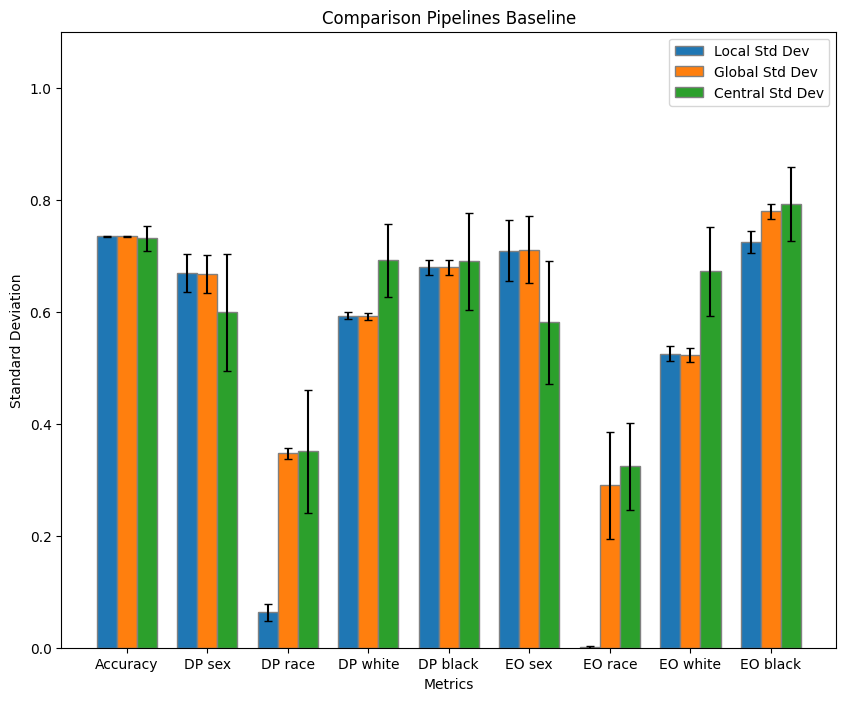

In [5]:
###########################################
# EXPERIMENT 1: baseline
###########################################

file_path = 'results_experiments_1.txt'
with open(file_path, 'r') as file:
    ex1_content = file.read()

# Extract values
( ex1_local_accuracies, ex1_local_equalized_odds, ex1_local_demographic_parities,
 ex1_global_accuracies, ex1_global_equalized_odds, ex1_global_demographic_parities, 
 ex1_central_accuracies, ex1_central_equalized_odds, ex1_central_demographic_parities
 , ex1_train_samples, ex1_test_samples) = extract_values(ex1_content)

print(ex1_central_accuracies)

ex1_local, ex1_global, ex1_central, ex1_diff_rq1, ex1_diff_rq2 = mean(ex1_local_accuracies, ex1_global_accuracies, ex1_central_accuracies, ex1_local_demographic_parities, ex1_global_demographic_parities, ex1_central_demographic_parities, ex1_local_equalized_odds, ex1_global_equalized_odds, ex1_central_equalized_odds)
print('Ex 1', ex1_local, ex1_global, ex1_central, ex1_diff_rq1, ex1_diff_rq2 )

ex1_local_stdev, ex1_global_stdev, ex1_central_stdev, ex1_rq1_stdev, ex1_rq2_stdev = calculate_stdev(ex1_local_accuracies, ex1_global_accuracies, ex1_central_accuracies, ex1_local_demographic_parities, ex1_global_demographic_parities, ex1_central_demographic_parities, ex1_local_equalized_odds, ex1_global_equalized_odds, ex1_central_equalized_odds)
plot_stdev(ex1_local, ex1_global, ex1_central, ex1_local_stdev, ex1_global_stdev, ex1_central_stdev, 'Baseline')

[0.735, 0.589, 0.348, 0.603, 0.665, 0.579, 0.345, 0.538, 0.772]
Ex 2 [0.735, 0.59, 0.092, 0.603, 0.664, 0.581, 0.003, 0.539, 0.712] [0.735, 0.589, 0.348, 0.603, 0.665, 0.579, 0.345, 0.538, 0.772] [0.747, 0.585, 0.314, 0.599, 0.677, 0.556, 0.305, 0.546, 0.796] [0.0, 0.001, -0.256, 0.0, -0.001, 0.002, -0.342, 0.001, -0.06] [-0.012, 0.004, 0.034, 0.004, -0.012, 0.023, 0.04, -0.008, -0.024]


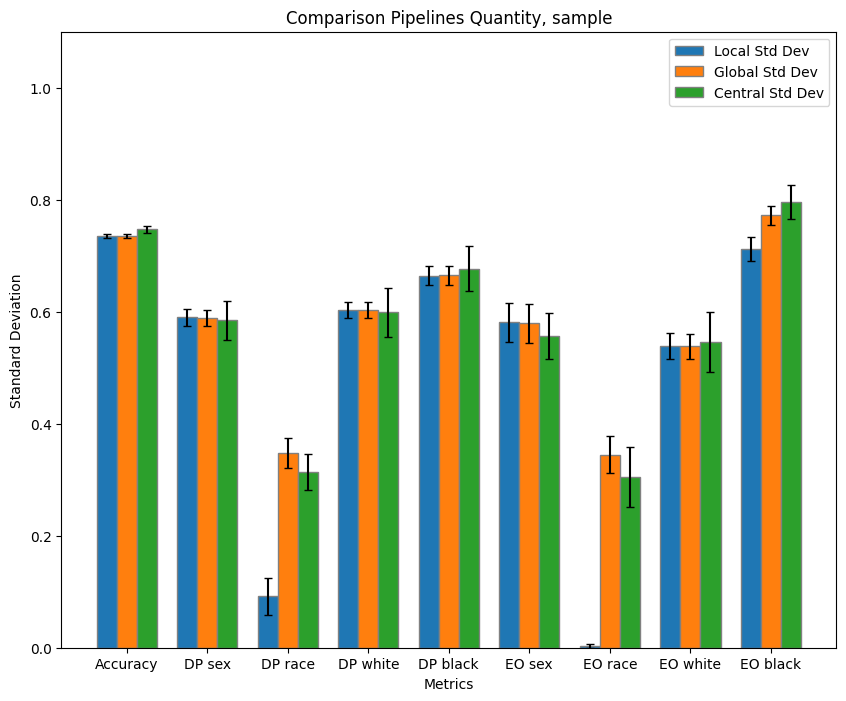

In [6]:
###########################################
# EXPERIMENT 2: Quantity (sample)
###########################################

file_path = 'results_experiments_2.txt'
with open(file_path, 'r') as file:
    ex2_content = file.read()

# Extract values
( ex2_local_accuracies, ex2_local_equalized_odds, ex2_local_demographic_parities,
 ex2_global_accuracies, ex2_global_equalized_odds, ex2_global_demographic_parities, 
 ex2_central_accuracies, ex2_central_equalized_odds, ex2_central_demographic_parities, 
 ex2_train_samples, ex2_test_samples) = extract_values(ex2_content)

ex2_local, ex2_global, ex2_central, ex2_diff_rq1, ex2_diff_rq2 = mean(ex2_local_accuracies, ex2_global_accuracies, ex2_central_accuracies, ex2_local_demographic_parities, ex2_global_demographic_parities, ex2_central_demographic_parities, ex2_local_equalized_odds, ex2_global_equalized_odds, ex2_central_equalized_odds)
print('Ex 2', ex2_local, ex2_global, ex2_central, ex2_diff_rq1, ex2_diff_rq2 )


ex2_local_stdev, ex2_global_stdev, ex2_central_stdev, ex2_rq1_stdev, ex2_rq2_stdev = calculate_stdev(ex2_local_accuracies, ex2_global_accuracies, ex2_central_accuracies, ex2_local_demographic_parities, ex2_global_demographic_parities, ex2_central_demographic_parities, ex2_local_equalized_odds, ex2_global_equalized_odds, ex2_central_equalized_odds)
plot_stdev(ex2_local, ex2_global, ex2_central, ex2_local_stdev, ex2_global_stdev, ex2_central_stdev, 'Quantity, sample')



[0.736, 0.578, 0.352, 0.586, 0.696, 0.548, 0.31, 0.514, 0.796]
Ex 3 [0.736, 0.577, 0.127, 0.579, 0.656, 0.538, 0.036, 0.517, 0.623] [0.736, 0.578, 0.352, 0.586, 0.696, 0.548, 0.31, 0.514, 0.796] [0.721, 0.665, 0.407, 0.71, 0.752, 0.65, 0.328, 0.683, 0.863] [0.0, -0.001, -0.225, -0.007, -0.04, -0.01, -0.274, 0.003, -0.173] [0.015, -0.087, -0.055, -0.124, -0.056, -0.102, -0.018, -0.169, -0.067]


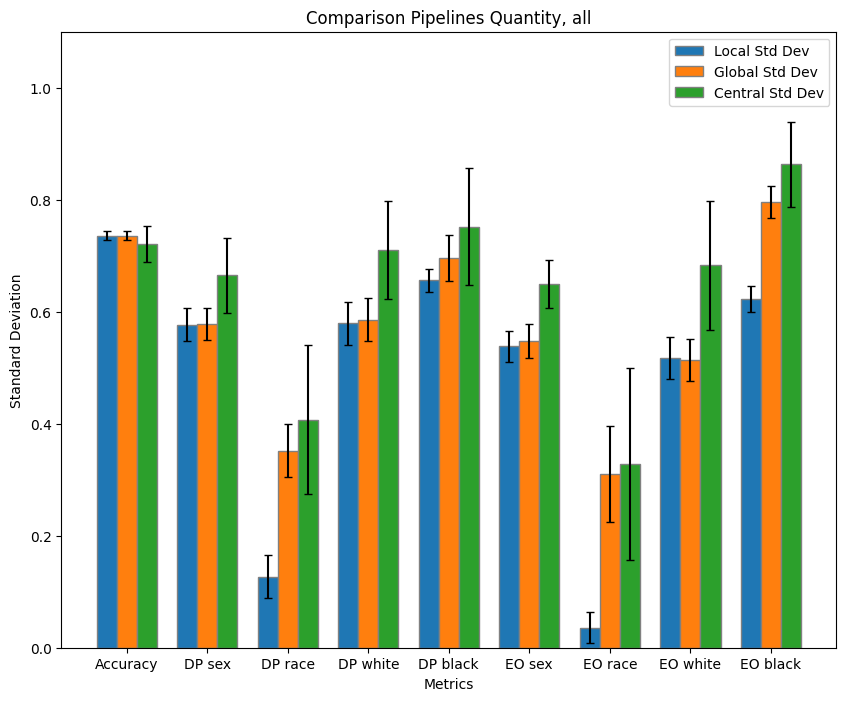

In [7]:
###########################################
# EXPERIMENT 3: Quantity (all)
###########################################

file_path = 'results_experiments_3.txt'
with open(file_path, 'r') as file:
    ex3_content = file.read()

# Extract values
( ex3_local_accuracies, ex3_local_equalized_odds, ex3_local_demographic_parities,
 ex3_global_accuracies, ex3_global_equalized_odds, ex3_global_demographic_parities, 
 ex3_central_accuracies, ex3_central_equalized_odds, ex3_central_demographic_parities, 
 ex3_train_samples, ex3_test_samples) = extract_values(ex3_content)

ex3_local, ex3_global, ex3_central, ex3_diff_rq1, ex3_diff_rq2 = mean(ex3_local_accuracies, ex3_global_accuracies, ex3_central_accuracies, ex3_local_demographic_parities, ex3_global_demographic_parities, ex3_central_demographic_parities, ex3_local_equalized_odds, ex3_global_equalized_odds, ex3_central_equalized_odds)
print('Ex 3', ex3_local, ex3_global, ex3_central, ex3_diff_rq1, ex3_diff_rq2 )

ex3_local_stdev, ex3_global_stdev, ex3_central_stdev, ex3_rq1_stdev, ex3_rq2_stdev = calculate_stdev(ex3_local_accuracies, ex3_global_accuracies, ex3_central_accuracies, ex3_local_demographic_parities, ex3_global_demographic_parities, ex3_central_demographic_parities, ex3_local_equalized_odds, ex3_global_equalized_odds, ex3_central_equalized_odds)
plot_stdev(ex3_local, ex3_global, ex3_central, ex3_local_stdev, ex3_global_stdev, ex3_central_stdev, 'Quantity, all')


[0.741, 0.591, 0.355, 0.607, 0.713, 0.548, 0.33, 0.533, 0.808]
Ex 4 [0.741, 0.59, 0.158, 0.604, 0.704, 0.538, 0.074, 0.538, 0.622] [0.741, 0.591, 0.355, 0.607, 0.713, 0.548, 0.33, 0.533, 0.808] [0.726, 0.657, 0.423, 0.728, 0.778, 0.616, 0.39, 0.712, 0.876] [0.0, -0.001, -0.197, -0.003, -0.009, -0.01, -0.256, 0.005, -0.186] [0.015, -0.066, -0.068, -0.121, -0.065, -0.068, -0.06, -0.179, -0.068]


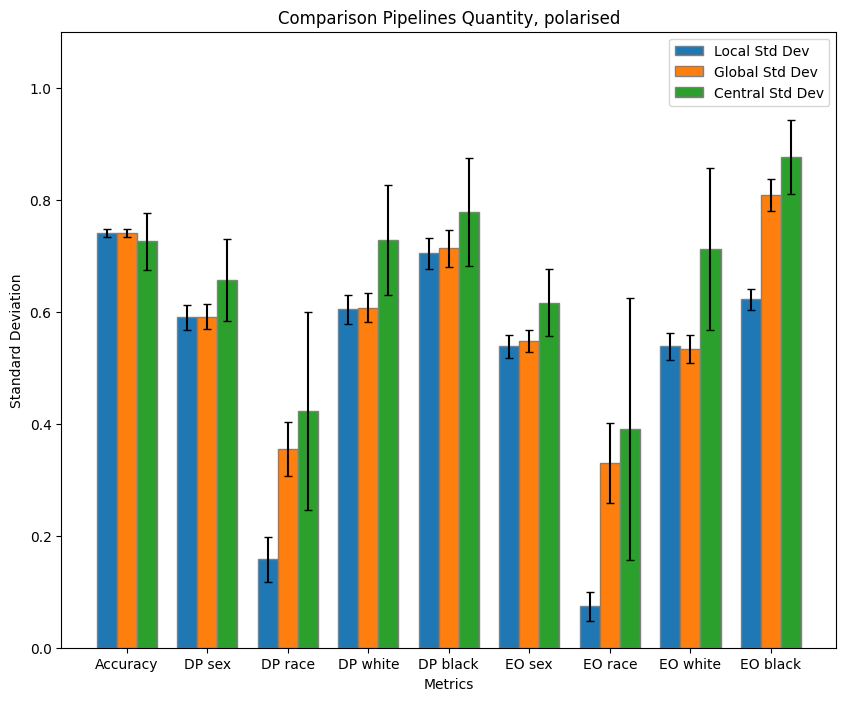

In [8]:
###########################################
# EXPERIMENT 4: Quantity (polarised)
###########################################

file_path = 'results_experiments_4.txt'
with open(file_path, 'r') as file:
    ex4_content = file.read()

# Extract values
( ex4_local_accuracies, ex4_local_equalized_odds, ex4_local_demographic_parities,
 ex4_global_accuracies, ex4_global_equalized_odds, ex4_global_demographic_parities, 
 ex4_central_accuracies, ex4_central_equalized_odds, ex4_central_demographic_parities, 
 ex4_train_samples, ex4_test_samples) = extract_values(ex4_content)

ex4_local, ex4_global, ex4_central, ex4_diff_rq1, ex4_diff_rq2 = mean(ex4_local_accuracies, ex4_global_accuracies, ex4_central_accuracies, ex4_local_demographic_parities, ex4_global_demographic_parities, ex4_central_demographic_parities, ex4_local_equalized_odds, ex4_global_equalized_odds, ex4_central_equalized_odds)
print('Ex 4', ex4_local, ex4_global, ex4_central, ex4_diff_rq1, ex4_diff_rq2 )


ex4_local_stdev, ex4_global_stdev, ex4_central_stdev, ex4_rq1_stdev, ex4_rq2_stdev = calculate_stdev(ex4_local_accuracies, ex4_global_accuracies, ex4_central_accuracies, ex4_local_demographic_parities, ex4_global_demographic_parities, ex4_central_demographic_parities, ex4_local_equalized_odds, ex4_global_equalized_odds, ex4_central_equalized_odds)
plot_stdev(ex4_local, ex4_global, ex4_central, ex4_local_stdev, ex4_global_stdev, ex4_central_stdev, 'Quantity, polarised')


[0.728, 0.687, 0.301, 0.495, 0.606, 0.77, 0.258, 0.473, 0.714]
Ex 5 [0.728, 0.687, 0.061, 0.5, 0.525, 0.729, 0.013, 0.445, 0.465] [0.728, 0.687, 0.301, 0.495, 0.606, 0.77, 0.258, 0.473, 0.714] [0.734, 0.467, 0.331, 0.557, 0.594, 0.441, 0.252, 0.574, 0.725] [0.0, 0.0, -0.24, 0.005, -0.081, -0.041, -0.245, -0.028, -0.249] [-0.006, 0.22, -0.03, -0.062, 0.012, 0.329, 0.006, -0.101, -0.011]


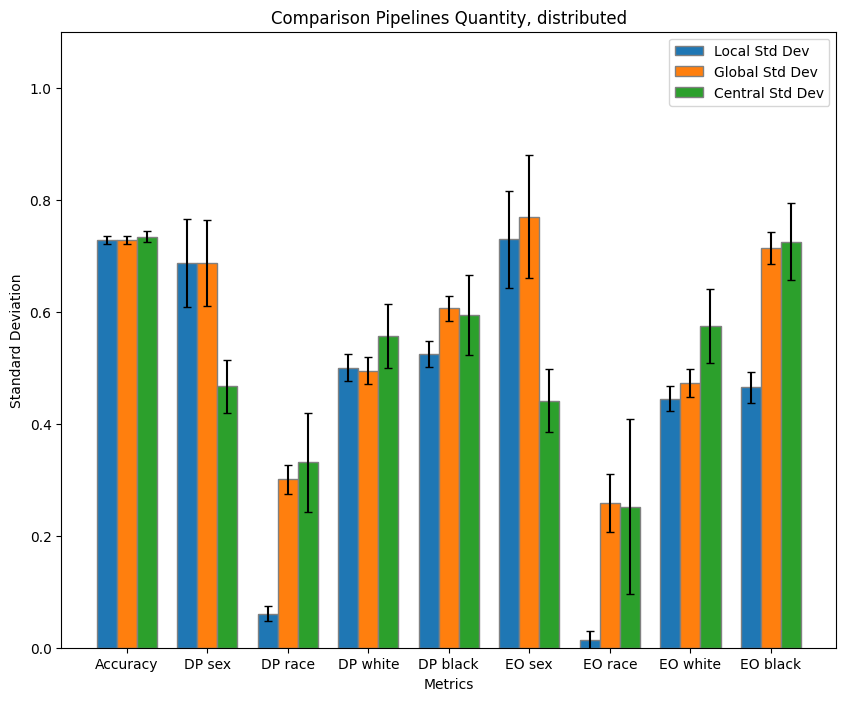

In [9]:
###########################################
# EXPERIMENT 5: Quantity (distributed)
###########################################

file_path = 'results_experiments_5.txt'
with open(file_path, 'r') as file:
    ex5_content = file.read()

# Extract values
( ex5_local_accuracies, ex5_local_equalized_odds, ex5_local_demographic_parities,
 ex5_global_accuracies, ex5_global_equalized_odds, ex5_global_demographic_parities, 
 ex5_central_accuracies, ex5_central_equalized_odds, ex5_central_demographic_parities, 
 ex5_train_samples, ex5_test_samples) = extract_values(ex5_content)

ex5_local, ex5_global, ex5_central, ex5_diff_rq1, ex5_diff_rq2 = mean(ex5_local_accuracies, ex5_global_accuracies, ex5_central_accuracies, ex5_local_demographic_parities, ex5_global_demographic_parities, ex5_central_demographic_parities, ex5_local_equalized_odds, ex5_global_equalized_odds, ex5_central_equalized_odds)
print('Ex 5', ex5_local, ex5_global, ex5_central, ex5_diff_rq1, ex5_diff_rq2 )


ex5_local_stdev, ex5_global_stdev, ex5_central_stdev, ex5_rq1_stdev, ex5_rq2_stdev = calculate_stdev(ex5_local_accuracies, ex5_global_accuracies, ex5_central_accuracies, ex5_local_demographic_parities, ex5_global_demographic_parities, ex5_central_demographic_parities, ex5_local_equalized_odds, ex5_global_equalized_odds, ex5_central_equalized_odds)
plot_stdev(ex5_local, ex5_global, ex5_central, ex5_local_stdev, ex5_global_stdev, ex5_central_stdev, 'Quantity, distributed')


[[0.9950923387073359, 0.8040596749514992, 0.46627386222381534, 0.9913448278278445, 0.996273652112167], [0.9451245310712999, 0.0, 0.06, 0.8328335678846533, 0.8938067407172735], [0.10866318712993897, 0.5955362673270491, 0.2695021206074941, 0.7317450088599067, 0.954701296840251], [0.1870925223622348, 0.5030304553881142, 0.21537980292236822, 0.2757072607164752, 0.6324816921573215]]
[0.494, 0.921, 0.626, 0.387, 0.5, 0.9, 0.6, 0.58, 0.488]
Ex 6 [0.494, 0.851, 0.546, 0.532, 0.363, 0.851, 0.546, 0.532, 0.363] [0.494, 0.921, 0.626, 0.387, 0.5, 0.9, 0.6, 0.58, 0.488] [0.698, 0.698, 0.483, 0.749, 0.774, 0.655, 0.488, 0.713, 0.855] [0.0, -0.07, -0.08, 0.145, -0.137, -0.049, -0.054, -0.048, -0.125] [-0.204, 0.223, 0.143, -0.362, -0.274, 0.245, 0.112, -0.133, -0.367]


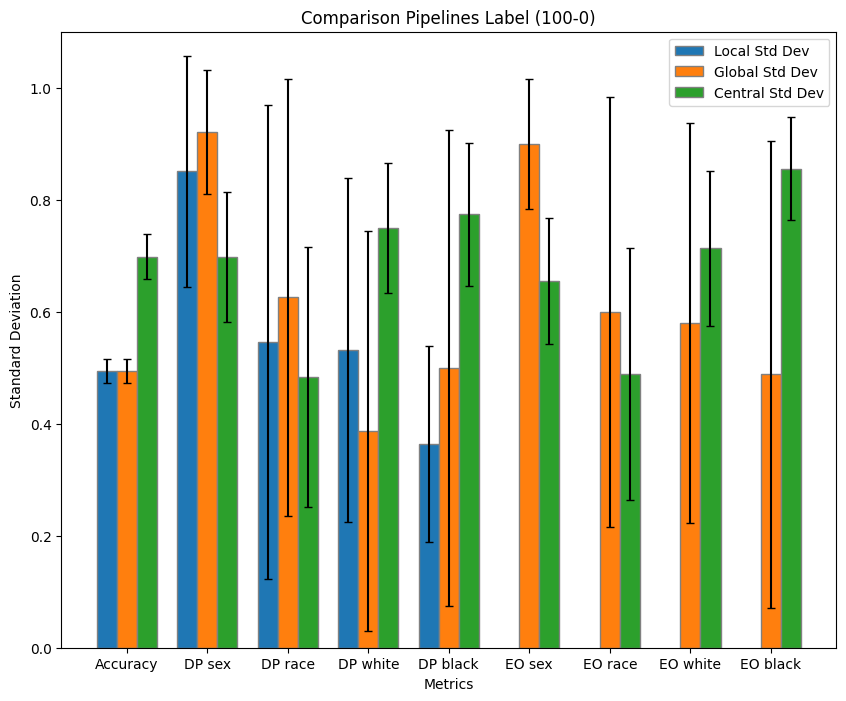

In [10]:
###########################################
# EXPERIMENT 6: Label (100-0)
###########################################

file_path = 'results_experiments_6.txt'
with open(file_path, 'r') as file:
    ex6_content = file.read()

# Extract values
( ex6_local_accuracies, ex6_local_equalized_odds, ex6_local_demographic_parities,
 ex6_global_accuracies, ex6_global_equalized_odds, ex6_global_demographic_parities, 
 ex6_central_accuracies, ex6_central_equalized_odds, ex6_central_demographic_parities, 
 ex6_train_samples, ex6_test_samples) = extract_values(ex6_content)

print(ex6_local_equalized_odds)

ex6_local, ex6_global, ex6_central, ex6_diff_rq1, ex6_diff_rq2 = mean(ex6_local_accuracies, ex6_global_accuracies, ex6_central_accuracies, ex6_local_demographic_parities, ex6_global_demographic_parities, ex6_central_demographic_parities, ex6_local_equalized_odds, ex6_global_equalized_odds, ex6_central_equalized_odds)
print('Ex 6', ex6_local, ex6_global, ex6_central, ex6_diff_rq1, ex6_diff_rq2 )

ex6_local = [ex6_local[i] if i not in [5, 6, 7, 8] else np.nan for i in range(len(ex6_local))]

ex6_local_stdev, ex6_global_stdev, ex6_central_stdev, ex6_rq1_stdev, ex6_rq2_stdev = calculate_stdev(ex6_local_accuracies, ex6_global_accuracies, ex6_central_accuracies, ex6_local_demographic_parities, ex6_global_demographic_parities, ex6_central_demographic_parities, ex6_local_equalized_odds, ex6_global_equalized_odds, ex6_central_equalized_odds)
plot_stdev(ex6_local, ex6_global, ex6_central, ex6_local_stdev, ex6_global_stdev, ex6_central_stdev, 'Label (100-0)')


[0.737, 0.741, 0.405, 0.651, 0.731, 0.777, 0.392, 0.569, 0.803]
Ex 7 [0.737, 0.758, 0.116, 0.661, 0.753, 0.763, 0.017, 0.57, 0.729] [0.737, 0.741, 0.405, 0.651, 0.731, 0.777, 0.392, 0.569, 0.803] [0.698, 0.806, 0.687, 0.853, 0.893, 0.655, 0.488, 0.713, 0.855] [0.0, 0.017, -0.289, 0.01, 0.022, -0.014, -0.375, 0.001, -0.074] [0.039, -0.065, -0.282, -0.202, -0.162, 0.122, -0.096, -0.144, -0.052]


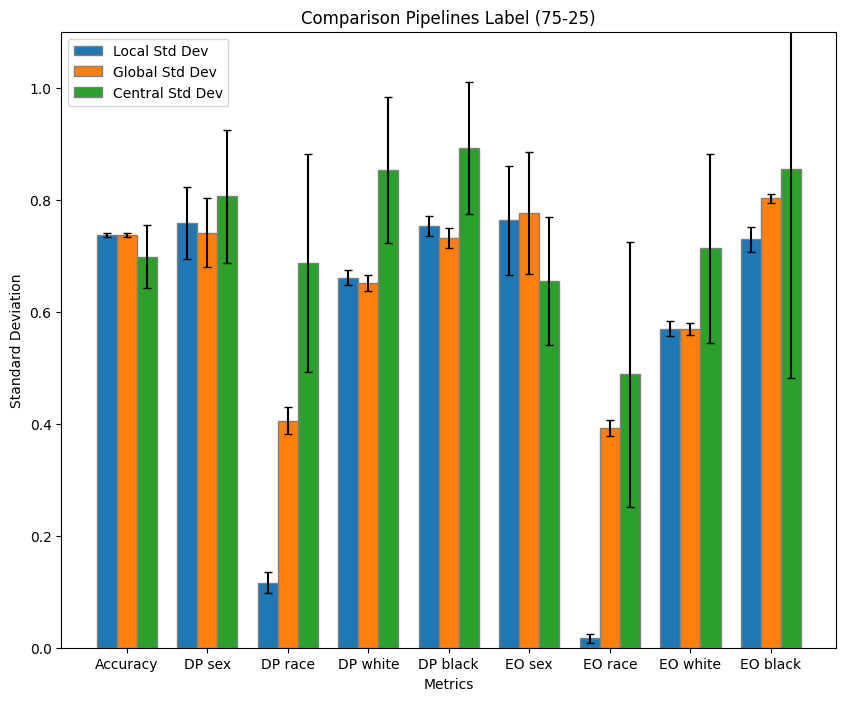

In [11]:
###########################################
# EXPERIMENT 7: Label (75-25)
###########################################

file_path = 'results_experiments_7.txt'
with open(file_path, 'r') as file:
    ex7_content = file.read()

# Extract values
( ex7_local_accuracies, ex7_local_equalized_odds, ex7_local_demographic_parities,
 ex7_global_accuracies, ex7_global_equalized_odds, ex7_global_demographic_parities, 
 ex7_central_accuracies, ex7_central_equalized_odds, ex7_central_demographic_parities, 
 ex7_train_samples, ex7_test_samples) = extract_values(ex7_content)

ex7_local, ex7_global, ex7_central, ex7_diff_rq1, ex7_diff_rq2 = mean(ex7_local_accuracies, ex7_global_accuracies, ex6_central_accuracies, ex7_local_demographic_parities, ex7_global_demographic_parities, ex7_central_demographic_parities, ex7_local_equalized_odds, ex7_global_equalized_odds, ex6_central_equalized_odds)
print('Ex 7', ex7_local, ex7_global, ex7_central, ex7_diff_rq1, ex7_diff_rq2 )

ex7_local_stdev, ex7_global_stdev, ex7_central_stdev, ex7_rq1_stdev, ex7_rq2_stdev = calculate_stdev(ex7_local_accuracies, ex7_global_accuracies, ex7_central_accuracies, ex7_local_demographic_parities, ex7_global_demographic_parities, ex7_central_demographic_parities, ex7_local_equalized_odds, ex7_global_equalized_odds, ex7_central_equalized_odds)
plot_stdev(ex7_local, ex7_global, ex7_central, ex7_local_stdev, ex7_global_stdev, ex7_central_stdev, 'Label (75-25)')

[0.727, 0.866, 0.326, 0.584, 0.69, 0.822, 0.308, 0.491, 0.777]
Ex 8 [0.727, 1.0, 0.048, 0.584, 0.695, 1.0, 0.001, 0.494, 0.726] [0.727, 0.866, 0.326, 0.584, 0.69, 0.822, 0.308, 0.491, 0.777] [0.722, 0.65, 0.413, 0.714, 0.75, 0.616, 0.452, 0.683, 0.853] [0.0, 0.134, -0.278, 0.0, 0.005, 0.178, -0.307, 0.003, -0.051] [0.005, 0.216, -0.087, -0.13, -0.06, 0.206, -0.144, -0.192, -0.076]


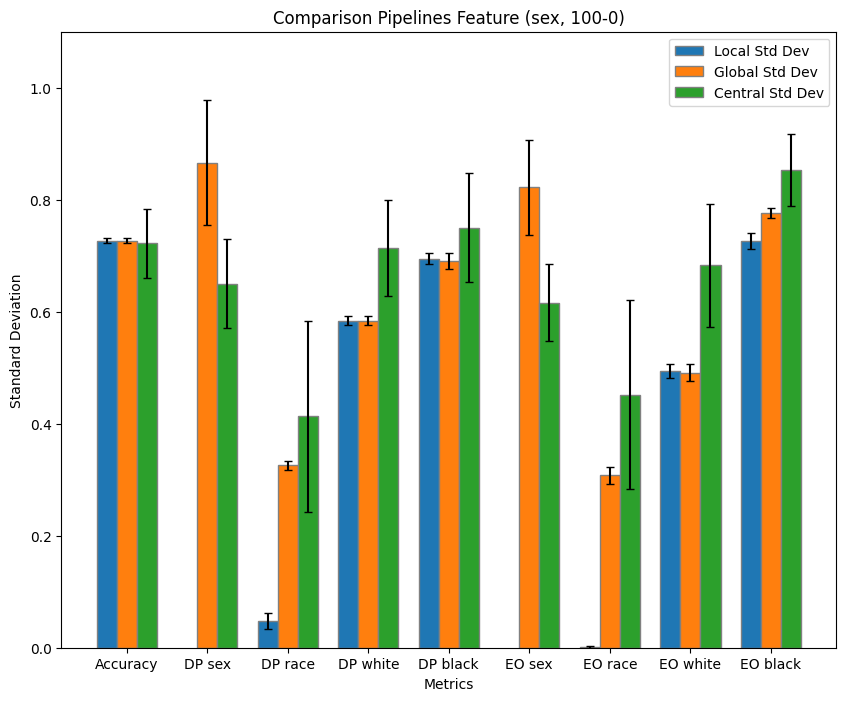

In [12]:
###########################################
# EXPERIMENT 8: Feature (Sex, 100-0)
###########################################

file_path = 'results_experiments_8.txt'
with open(file_path, 'r') as file:
    ex8_content = file.read()

# Extract values
( ex8_local_accuracies, ex8_local_equalized_odds, ex8_local_demographic_parities,
 ex8_global_accuracies, ex8_global_equalized_odds, ex8_global_demographic_parities, 
 ex8_central_accuracies, ex8_central_equalized_odds, ex8_central_demographic_parities, 
 ex8_train_samples, ex8_test_samples) = extract_values(ex8_content)

ex8_local, ex8_global, ex8_central, ex8_diff_rq1, ex8_diff_rq2 = mean(ex8_local_accuracies, ex8_global_accuracies, ex8_central_accuracies, ex8_local_demographic_parities, ex8_global_demographic_parities, ex8_central_demographic_parities, ex8_local_equalized_odds, ex8_global_equalized_odds, ex8_central_equalized_odds)
print('Ex 8', ex8_local, ex8_global, ex8_central, ex8_diff_rq1, ex8_diff_rq2)

ex8_local = [ex8_local[i] if i not in [1, 5] else np.nan for i in range(len(ex8_local))]

ex8_local_stdev, ex8_global_stdev, ex8_central_stdev, ex8_rq1_stdev, ex8_rq2_stdev = calculate_stdev(ex8_local_accuracies, ex8_global_accuracies, ex8_central_accuracies, ex8_local_demographic_parities, ex8_global_demographic_parities, ex8_central_demographic_parities, ex8_local_equalized_odds, ex8_global_equalized_odds, ex8_central_equalized_odds)
plot_stdev(ex8_local, ex8_global, ex8_central, ex8_local_stdev, ex8_global_stdev, ex8_central_stdev, 'Feature (sex, 100-0)')


[0.734, 0.724, 0.344, 0.588, 0.676, 0.795, 0.308, 0.516, 0.775]
Ex 9 [0.734, 0.724, 0.047, 0.588, 0.679, 0.773, 0.007, 0.517, 0.7] [0.734, 0.724, 0.344, 0.588, 0.676, 0.795, 0.308, 0.516, 0.775] [0.687, 0.69, 0.506, 0.768, 0.815, 0.644, 0.474, 0.757, 0.89] [0.0, 0.0, -0.297, 0.0, 0.003, -0.022, -0.301, 0.001, -0.075] [0.047, 0.034, -0.162, -0.18, -0.139, 0.151, -0.166, -0.241, -0.115]


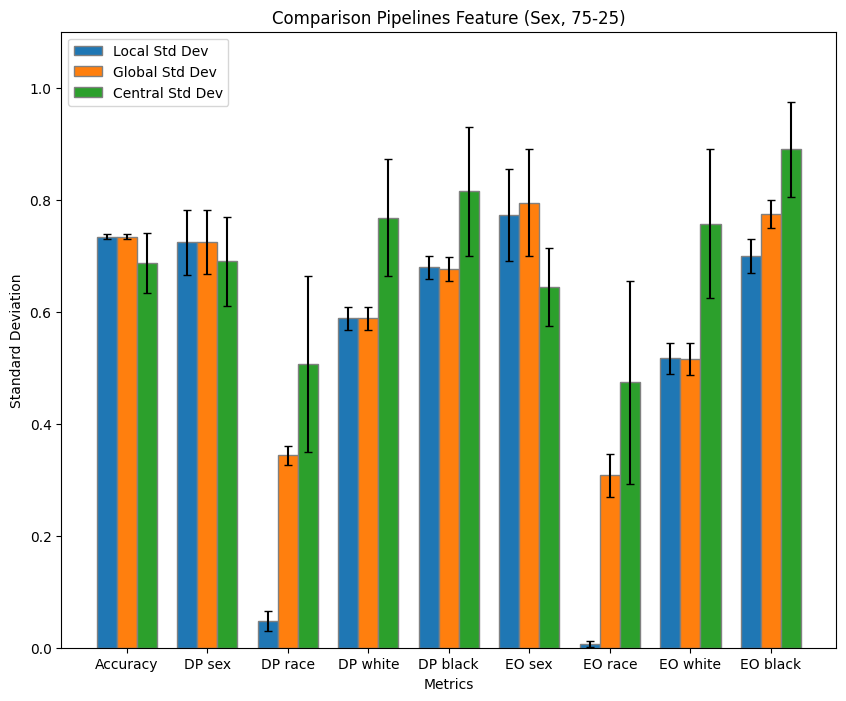

In [13]:
###########################################
# EXPERIMENT 9: Feature (Sex, 75-25)
###########################################

file_path = 'results_experiments_9.txt'
with open(file_path, 'r') as file:
    ex9_content = file.read()

# Extract values
( ex9_local_accuracies, ex9_local_equalized_odds, ex9_local_demographic_parities,
 ex9_global_accuracies, ex9_global_equalized_odds, ex9_global_demographic_parities, 
 ex9_central_accuracies, ex9_central_equalized_odds, ex9_central_demographic_parities, 
 ex9_train_samples, ex9_test_samples) = extract_values(ex9_content)

ex9_local, ex9_global, ex9_central, ex9_diff_rq1, ex9_diff_rq2 = mean(ex9_local_accuracies, ex9_global_accuracies, ex9_central_accuracies, ex9_local_demographic_parities, ex9_global_demographic_parities, ex9_central_demographic_parities, ex9_local_equalized_odds, ex9_global_equalized_odds, ex9_central_equalized_odds)
print('Ex 9', ex9_local, ex9_global, ex9_central, ex9_diff_rq1, ex9_diff_rq2)

ex9_local_stdev, ex9_global_stdev, ex9_central_stdev, ex9_rq1_stdev, ex9_rq2_stdev = calculate_stdev(ex9_local_accuracies, ex9_global_accuracies, ex9_central_accuracies, ex9_local_demographic_parities, ex9_global_demographic_parities, ex9_central_demographic_parities, ex9_local_equalized_odds, ex9_global_equalized_odds, ex9_central_equalized_odds)
plot_stdev(ex9_local, ex9_global, ex9_central, ex9_local_stdev, ex9_global_stdev, ex9_central_stdev, 'Feature (Sex, 75-25)')

[0.658, 0.603, 0.017, 0.678, 0.348, 0.342, 0.0, 0.781, 0.162]
Ex 10 [0.658, 0.765, 1.0, 0.889, 0.111, 0.748, 1.0, 0.889, 0.111] [0.658, 0.603, 0.017, 0.678, 0.348, 0.342, 0.0, 0.781, 0.162] [0.666, 0.904, 0.392, 0.584, 0.273, 0.852, 0.283, 0.57, 0.396] [0.0, 0.162, 0.983, 0.211, -0.237, 0.406, 1.0, 0.108, -0.051] [-0.008, -0.301, -0.375, 0.094, 0.075, -0.51, -0.283, 0.211, -0.234]


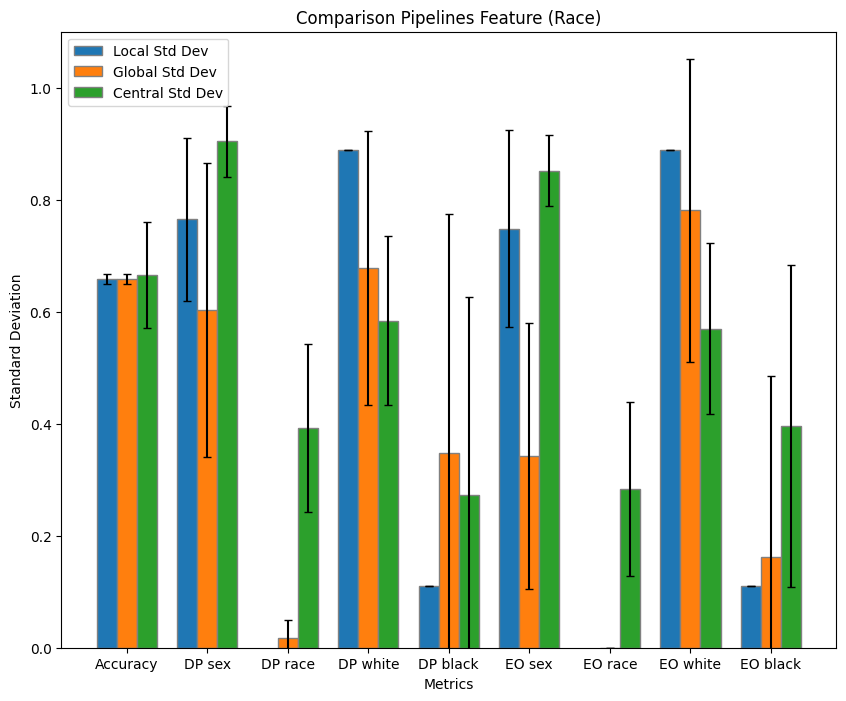

In [14]:
###########################################
# EXPERIMENT 10: Feature (Race)
###########################################

file_path = 'results_experiments_10.txt'
with open(file_path, 'r') as file:
    ex10_content = file.read()

# Extract values
( ex10_local_accuracies, ex10_local_equalized_odds, ex10_local_demographic_parities,
 ex10_global_accuracies, ex10_global_equalized_odds, ex10_global_demographic_parities, 
 ex10_central_accuracies, ex10_central_equalized_odds, ex10_central_demographic_parities, 
 ex10_train_samples, ex10_test_samples) = extract_values(ex10_content)

ex10_local, ex10_global, ex10_central, ex10_diff_rq1, ex10_diff_rq2 = mean(ex10_local_accuracies, ex10_global_accuracies, ex10_central_accuracies, ex10_local_demographic_parities, ex10_global_demographic_parities, ex10_central_demographic_parities, ex10_local_equalized_odds, ex10_global_equalized_odds, ex10_central_equalized_odds)
print('Ex 10', ex10_local, ex10_global, ex10_central, ex10_diff_rq1, ex10_diff_rq2)

ex10_local = [ex10_local[i] if i not in [2, 6] else np.nan for i in range(len(ex6_local))]

ex10_local_stdev, ex10_global_stdev, ex10_central_stdev, ex10_rq1_stdev, ex10_rq2_stdev = calculate_stdev(ex10_local_accuracies, ex10_global_accuracies, ex10_central_accuracies, ex10_local_demographic_parities, ex10_global_demographic_parities, ex10_central_demographic_parities, ex10_local_equalized_odds, ex10_global_equalized_odds, ex10_central_equalized_odds)
plot_stdev(ex10_local, ex10_global, ex10_central, ex10_local_stdev, ex10_global_stdev, ex10_central_stdev, 'Feature (Race)')

[0.543, 0.669, 0.197, 0.645, 0.589, 0.547, 0.082, 0.675, 0.625]
Ex 11 [0.543, 0.688, 0.058, 0.579, 0.496, 0.504, 0.005, 0.614, 0.423] [0.543, 0.669, 0.197, 0.645, 0.589, 0.547, 0.082, 0.675, 0.625] [0.647, 0.614, 0.274, 0.689, 0.869, 0.566, 0.175, 0.649, 0.7] [0.0, 0.019, -0.139, -0.066, -0.093, -0.043, -0.077, -0.061, -0.202] [-0.104, 0.055, -0.077, -0.044, -0.28, -0.019, -0.093, 0.026, -0.075]


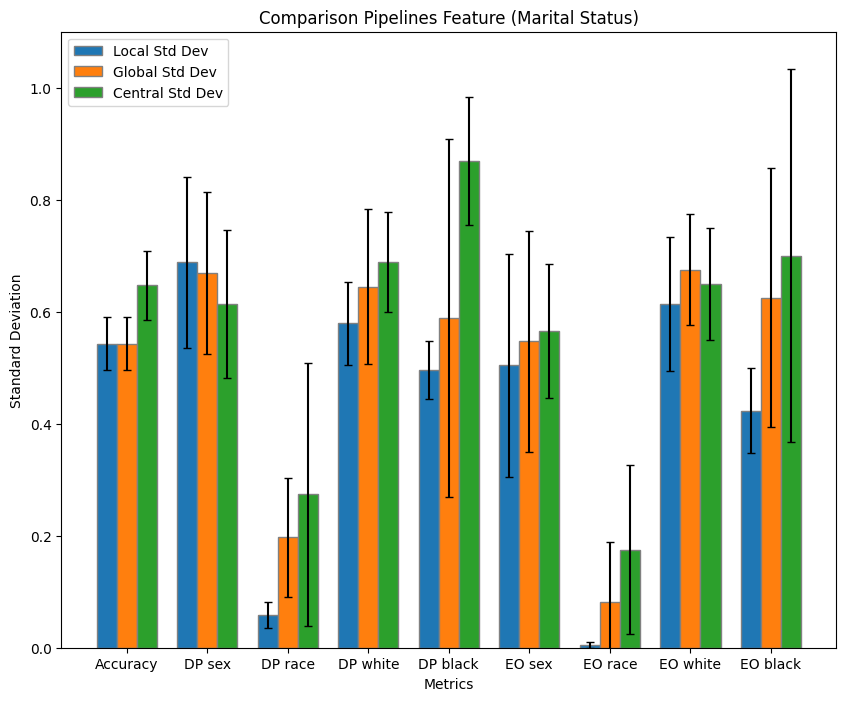

In [15]:
###########################################
# EXPERIMENT 11: Feature (MS)
###########################################

file_path = 'results_experiments_11.txt'
with open(file_path, 'r') as file:
    ex11_content = file.read()

# Extract values
( ex11_local_accuracies, ex11_local_equalized_odds, ex11_local_demographic_parities,
 ex11_global_accuracies, ex11_global_equalized_odds, ex11_global_demographic_parities, 
 ex11_central_accuracies, ex11_central_equalized_odds, ex11_central_demographic_parities, 
 ex11_train_samples, ex11_test_samples) = extract_values(ex11_content)

ex11_local, ex11_global, ex11_central, ex11_diff_rq1, ex11_diff_rq2 = mean(ex11_local_accuracies, ex11_global_accuracies, ex11_central_accuracies, ex11_local_demographic_parities, ex11_global_demographic_parities, ex11_central_demographic_parities, ex11_local_equalized_odds, ex11_global_equalized_odds, ex11_central_equalized_odds)
print('Ex 11', ex11_local, ex11_global, ex11_central, ex11_diff_rq1, ex11_diff_rq2)


ex11_local_stdev, ex11_global_stdev, ex11_central_stdev, ex11_rq1_stdev, ex11_rq2_stdev = calculate_stdev(ex11_local_accuracies, ex11_global_accuracies, ex11_central_accuracies, ex11_local_demographic_parities, ex11_global_demographic_parities, ex11_central_demographic_parities, ex11_local_equalized_odds, ex11_global_equalized_odds, ex11_central_equalized_odds)
plot_stdev(ex11_local, ex11_global, ex11_central, ex11_local_stdev, ex11_global_stdev, ex11_central_stdev, 'Feature (Marital Status)')

[0.7965920220544804, 0.7987530123266976, 0.7964711288221312, 0.3449186298443218, 0.7964593315717806]
[0.7987450948332243, 0.8008604480052322, 0.7986326847612819, 0.3448843198168738, 0.7986224656638325]
[0.708, 0.751, 0.058, 0.656, 0.427, 0.594, 0.038, 0.756, 0.578]
Ex 12 [0.707, 0.71, 0.396, 0.39, 0.481, 0.71, 0.396, 0.39, 0.481] [0.708, 0.751, 0.058, 0.656, 0.427, 0.594, 0.038, 0.756, 0.578] [0.826, 0.262, 0.166, 0.517, 0.546, 0.256, 0.069, 0.521, 0.665] [-0.001, -0.041, 0.338, -0.266, 0.054, 0.116, 0.358, -0.366, -0.097] [-0.118, 0.489, -0.108, 0.139, -0.119, 0.338, -0.031, 0.235, -0.087]


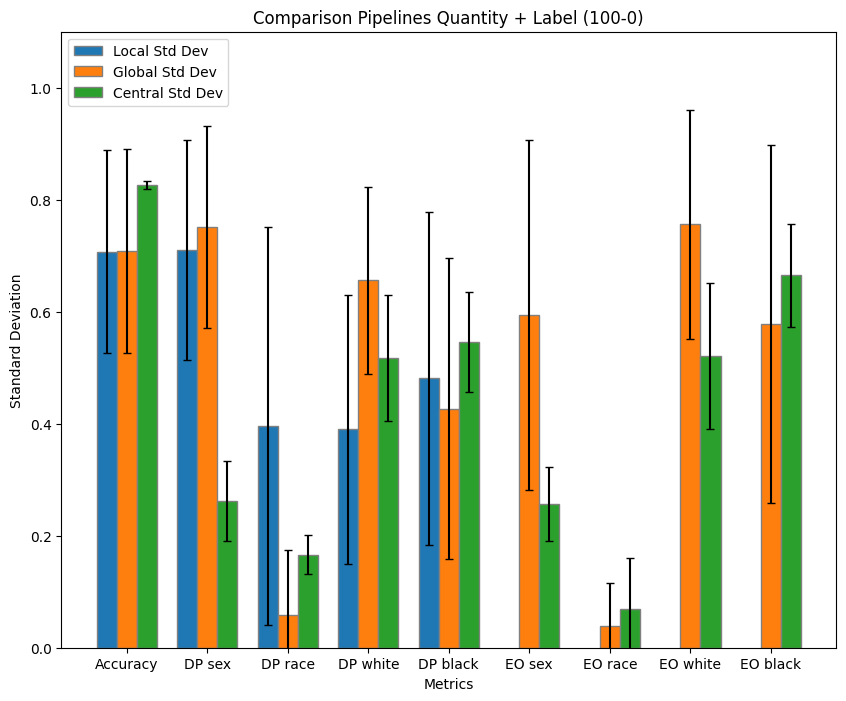

In [16]:
###########################################
# EXPERIMENT 12: Quantity + Label (100-0)
###########################################

file_path = 'results_experiments_12.txt'
with open(file_path, 'r') as file:
    ex12_content = file.read()

# Extract values
( ex12_local_accuracies, ex12_local_equalized_odds, ex12_local_demographic_parities,
 ex12_global_accuracies, ex12_global_equalized_odds, ex12_global_demographic_parities, 
 ex12_central_accuracies, ex12_central_equalized_odds, ex12_central_demographic_parities, 
 ex12_train_samples, ex12_test_samples) = extract_values(ex12_content)

print(ex12_local_accuracies)
print(ex12_global_accuracies)


ex12_local, ex12_global, ex12_central, ex12_diff_rq1, ex12_diff_rq2 = mean(ex12_local_accuracies, ex12_global_accuracies, ex12_central_accuracies, ex12_local_demographic_parities, ex12_global_demographic_parities, ex12_central_demographic_parities, ex12_local_equalized_odds, ex12_global_equalized_odds, ex12_central_equalized_odds)
print('Ex 12', ex12_local, ex12_global, ex12_central, ex12_diff_rq1, ex12_diff_rq2)

ex12_local = [ex12_local[i] if i not in [5, 6, 7, 8] else np.nan for i in range(len(ex12_local))]

ex12_local_stdev, ex12_global_stdev, ex12_central_stdev, ex12_rq1_stdev, ex12_rq2_stdev = calculate_stdev(ex12_local_accuracies, ex12_global_accuracies, ex12_central_accuracies, ex12_local_demographic_parities, ex12_global_demographic_parities, ex12_central_demographic_parities, ex12_local_equalized_odds, ex12_global_equalized_odds, ex12_central_equalized_odds)
plot_stdev(ex12_local, ex12_global, ex12_central, ex12_local_stdev, ex12_global_stdev, ex12_central_stdev, 'Quantity + Label (100-0)')

[0.707, 0.909, 0.446, 0.687, 0.808, 0.788, 0.386, 0.619, 0.871]
Ex 13 [0.707, 0.895, 0.124, 0.695, 0.724, nan, nan, nan, nan] [0.707, 0.909, 0.446, 0.687, 0.808, 0.788, 0.386, 0.619, 0.871] [0.691, 0.704, 0.481, 0.741, 0.817, 0.639, 0.364, 0.676, 0.689] [0.0, -0.014, -0.322, 0.008, -0.084, nan, nan, nan, nan] [0.016, 0.205, -0.035, -0.054, -0.009, 0.149, 0.022, -0.057, 0.182]


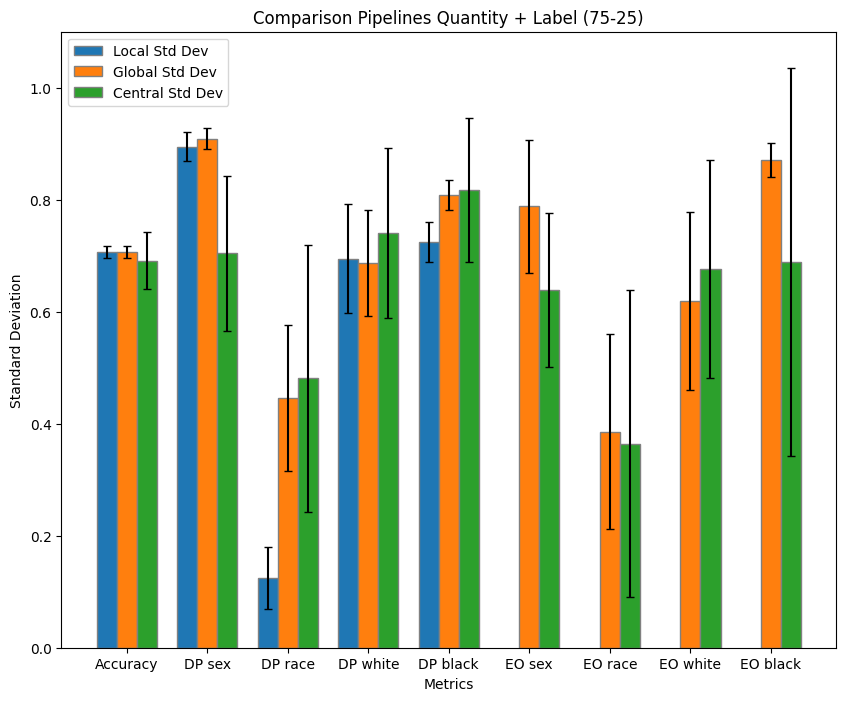

In [17]:
###########################################
# EXPERIMENT 13: Quantity + Label (75-25)
###########################################

file_path = 'results_experiments_13.txt'
with open(file_path, 'r') as file:
    ex13_content = file.read()

# Extract values
( ex13_local_accuracies, ex13_local_equalized_odds, ex13_local_demographic_parities,
 ex13_global_accuracies, ex13_global_equalized_odds, ex13_global_demographic_parities, 
 ex13_central_accuracies, ex13_central_equalized_odds, ex13_central_demographic_parities, 
 ex13_train_samples, ex13_test_samples) = extract_values(ex13_content)

ex13_local, ex13_global, ex13_central, ex13_diff_rq1, ex13_diff_rq2 = mean(ex13_local_accuracies, ex13_global_accuracies, ex13_central_accuracies, ex13_local_demographic_parities, ex13_global_demographic_parities, ex13_central_demographic_parities, ex13_local_equalized_odds, ex13_global_equalized_odds, ex13_central_equalized_odds)
print('Ex 13', ex13_local, ex13_global, ex13_central, ex13_diff_rq1, ex13_diff_rq2)

ex13_local_stdev, ex13_global_stdev, ex13_central_stdev, ex13_rq1_stdev, ex13_rq2_stdev = calculate_stdev(ex13_local_accuracies, ex13_global_accuracies, ex13_central_accuracies, ex13_local_demographic_parities, ex13_global_demographic_parities, ex13_central_demographic_parities, ex13_local_equalized_odds, ex13_global_equalized_odds, ex13_central_equalized_odds)
plot_stdev(ex13_local, ex13_global, ex13_central, ex13_local_stdev, ex13_global_stdev, ex13_central_stdev, 'Quantity + Label (75-25)')

[0.718, 0.847, 0.305, 0.555, 0.682, 0.712, 0.275, 0.471, 0.774]
Ex 14 [0.718, 1.0, 0.101, 0.552, 0.648, 1.0, 0.01, 0.483, 0.625] [0.718, 0.847, 0.305, 0.555, 0.682, 0.712, 0.275, 0.471, 0.774] [0.667, 0.735, 0.581, 0.777, 0.849, 0.706, 0.571, 0.753, 0.718] [0.0, 0.153, -0.204, -0.003, -0.034, 0.288, -0.265, 0.012, -0.149] [0.051, 0.112, -0.276, -0.222, -0.167, 0.006, -0.296, -0.282, 0.056]


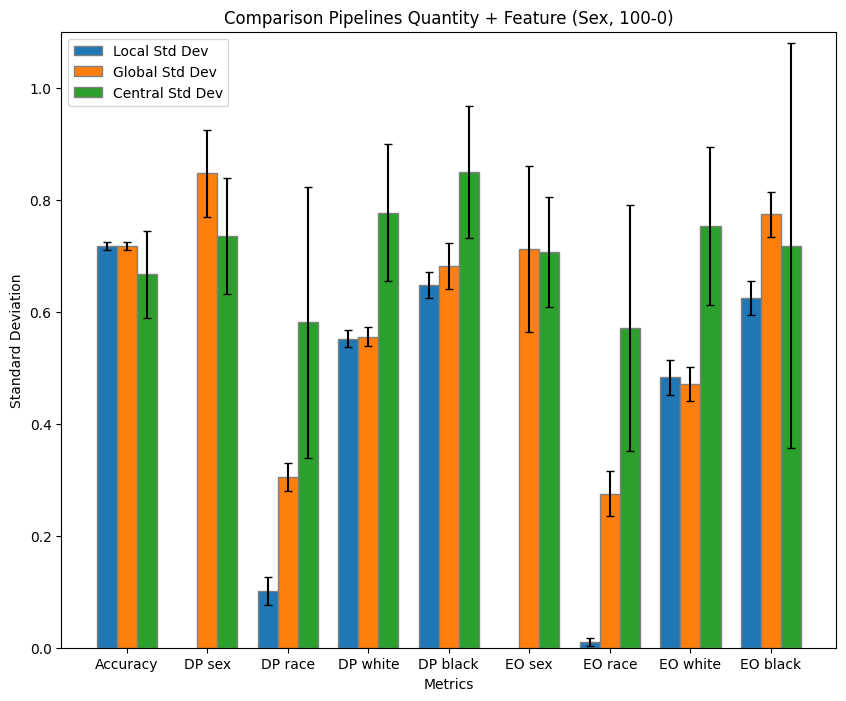

In [18]:
###########################################
# EXPERIMENT 14: Quantity + Feature (Sex, 100-0)
###########################################

file_path = 'results_experiments_14.txt'
with open(file_path, 'r') as file:
    ex14_content = file.read()

# Extract values
( ex14_local_accuracies, ex14_local_equalized_odds, ex14_local_demographic_parities,
 ex14_global_accuracies, ex14_global_equalized_odds, ex14_global_demographic_parities, 
 ex14_central_accuracies, ex14_central_equalized_odds, ex14_central_demographic_parities, 
 ex14_train_samples, ex14_test_samples) = extract_values(ex14_content)

ex14_local, ex14_global, ex14_central, ex14_diff_rq1, ex14_diff_rq2 = mean(ex14_local_accuracies, ex14_global_accuracies, ex14_central_accuracies, ex14_local_demographic_parities, ex14_global_demographic_parities, ex14_central_demographic_parities, ex14_local_equalized_odds, ex14_global_equalized_odds, ex14_central_equalized_odds)
print('Ex 14', ex14_local, ex14_global, ex14_central, ex14_diff_rq1, ex14_diff_rq2)

ex14_local = [ex14_local[i] if i not in [1, 5] else np.nan for i in range(len(ex14_local))]

ex14_local_stdev, ex14_global_stdev, ex14_central_stdev, ex14_rq1_stdev, ex14_rq2_stdev = calculate_stdev(ex14_local_accuracies, ex14_global_accuracies, ex14_central_accuracies, ex14_local_demographic_parities, ex14_global_demographic_parities, ex14_central_demographic_parities, ex14_local_equalized_odds, ex14_global_equalized_odds, ex14_central_equalized_odds)
plot_stdev(ex14_local, ex14_global, ex14_central, ex14_local_stdev, ex14_global_stdev, ex14_central_stdev, 'Quantity + Feature (Sex, 100-0)')

[0.717, 0.891, 0.271, 0.59, 0.71, 0.807, 0.23, 0.518, 0.796]
Ex 15 [0.717, 0.872, 0.047, 0.591, 0.661, 0.762, 0.014, 0.514, 0.575] [0.717, 0.891, 0.271, 0.59, 0.71, 0.807, 0.23, 0.518, 0.796] [0.714, 0.509, 0.251, 0.667, 0.644, 0.499, 0.17, 0.616, 0.72] [0.0, -0.019, -0.224, 0.001, -0.049, -0.045, -0.216, -0.004, -0.221] [0.003, 0.382, 0.02, -0.077, 0.066, 0.308, 0.06, -0.098, 0.076]


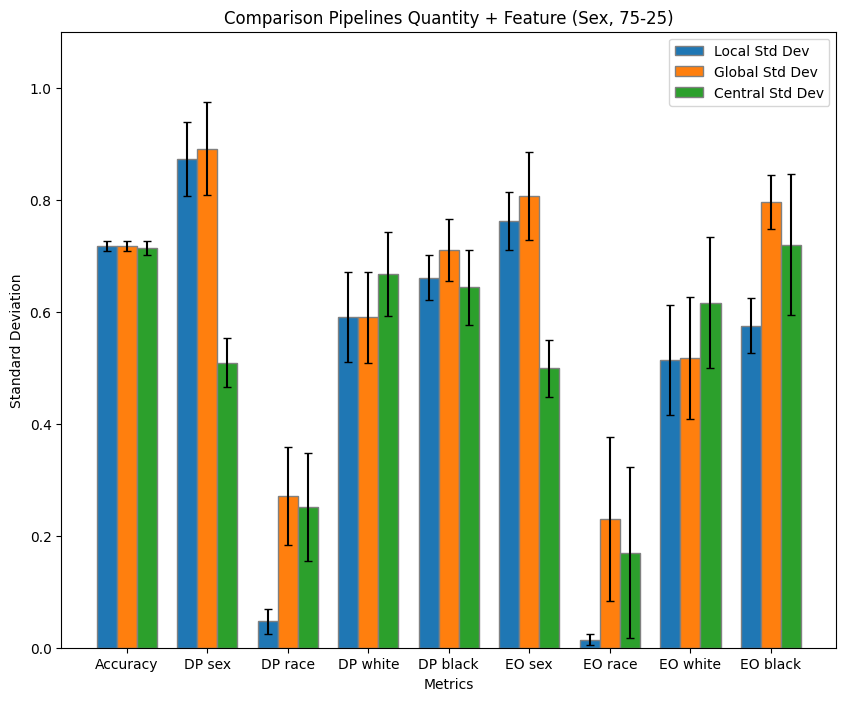

In [19]:
###########################################
# EXPERIMENT 15: Quantity + Feature (Sex, 75-25)
###########################################

file_path = 'results_experiments_15.txt'
with open(file_path, 'r') as file:
    ex15_content = file.read()

# Extract values
( ex15_local_accuracies, ex15_local_equalized_odds, ex15_local_demographic_parities,
 ex15_global_accuracies, ex15_global_equalized_odds, ex15_global_demographic_parities, 
 ex15_central_accuracies, ex15_central_equalized_odds, ex15_central_demographic_parities, 
 ex15_train_samples, ex15_test_samples) = extract_values(ex15_content)

ex15_local, ex15_global, ex15_central, ex15_diff_rq1, ex15_diff_rq2 = mean(ex15_local_accuracies, ex15_global_accuracies, ex15_central_accuracies, ex15_local_demographic_parities, ex15_global_demographic_parities, ex15_central_demographic_parities, ex15_local_equalized_odds, ex15_global_equalized_odds, ex15_central_equalized_odds)
print('Ex 15', ex15_local, ex15_global, ex15_central, ex15_diff_rq1, ex15_diff_rq2)

ex15_local_stdev, ex15_global_stdev, ex15_central_stdev, ex15_rq1_stdev, ex15_rq2_stdev = calculate_stdev(ex15_local_accuracies, ex15_global_accuracies, ex15_central_accuracies, ex15_local_demographic_parities, ex15_global_demographic_parities, ex15_central_demographic_parities, ex15_local_equalized_odds, ex15_global_equalized_odds, ex15_central_equalized_odds)
plot_stdev(ex15_local, ex15_global, ex15_central, ex15_local_stdev, ex15_global_stdev, ex15_central_stdev, 'Quantity + Feature (Sex, 75-25)')

[0.636, 0.835, 0.0, 0.142, 0.739, 0.843, 0.0, 0.119, 0.628]
Ex 16 [0.636, 0.814, 1.0, 0.331, 0.083, 0.785, 1.0, 0.331, 0.083] [0.636, 0.835, 0.0, 0.142, 0.739, 0.843, 0.0, 0.119, 0.628] [0.716, 0.607, 0.344, 0.662, 0.713, 0.577, 0.288, 0.628, 0.824] [0.0, -0.021, 1.0, 0.189, -0.656, -0.058, 1.0, 0.212, -0.545] [-0.08, 0.228, -0.344, -0.52, 0.026, 0.266, -0.288, -0.509, -0.196]


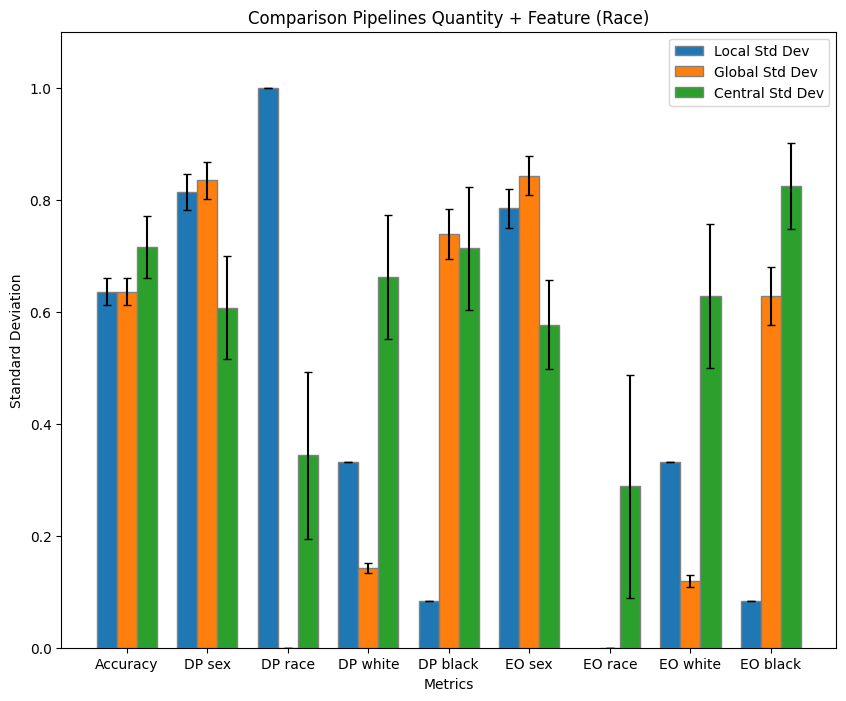

In [20]:
###########################################
# EXPERIMENT 16: Quantity + Feature (Race)
###########################################

file_path = 'results_experiments_16.txt'
with open(file_path, 'r') as file:
    ex16_content = file.read()

# Extract values
( ex16_local_accuracies, ex16_local_equalized_odds, ex16_local_demographic_parities,
 ex16_global_accuracies, ex16_global_equalized_odds, ex16_global_demographic_parities, 
 ex16_central_accuracies, ex16_central_equalized_odds, ex16_central_demographic_parities, 
 ex16_train_samples, ex16_test_samples) = extract_values(ex16_content)

ex16_local, ex16_global, ex16_central, ex16_diff_rq1, ex16_diff_rq2 = mean(ex16_local_accuracies, ex16_global_accuracies, ex16_central_accuracies, ex16_local_demographic_parities, ex16_global_demographic_parities, ex16_central_demographic_parities, ex16_local_equalized_odds, ex16_global_equalized_odds, ex16_central_equalized_odds)
print('Ex 16', ex16_local, ex16_global, ex16_central, ex16_diff_rq1, ex16_diff_rq2)

ex16_local = [ex16_local[i] if i not in [6] else np.nan for i in range(len(ex12_local))]

ex16_local_stdev, ex16_global_stdev, ex16_central_stdev, ex16_rq1_stdev, ex16_rq2_stdev = calculate_stdev(ex16_local_accuracies, ex16_global_accuracies, ex16_central_accuracies, ex16_local_demographic_parities, ex16_global_demographic_parities, ex16_central_demographic_parities, ex16_local_equalized_odds, ex16_global_equalized_odds, ex16_central_equalized_odds)
plot_stdev(ex16_local, ex16_global, ex16_central, ex16_local_stdev, ex16_global_stdev, ex16_central_stdev, 'Quantity + Feature (Race)')

[0.708, 0.757, 0.438, 0.665, 0.674, 0.839, 0.422, 0.622, 0.726]
Ex 17 [0.708, 0.548, 0.264, 0.653, 0.635, 0.486, 0.107, 0.595, 0.425] [0.708, 0.757, 0.438, 0.665, 0.674, 0.839, 0.422, 0.622, 0.726] [0.742, 0.602, 0.33, 0.686, 0.723, 0.567, 0.329, 0.667, 0.835] [0.0, -0.209, -0.174, -0.012, -0.039, -0.353, -0.315, -0.027, -0.301] [-0.034, 0.155, 0.108, -0.021, -0.049, 0.272, 0.093, -0.045, -0.109]


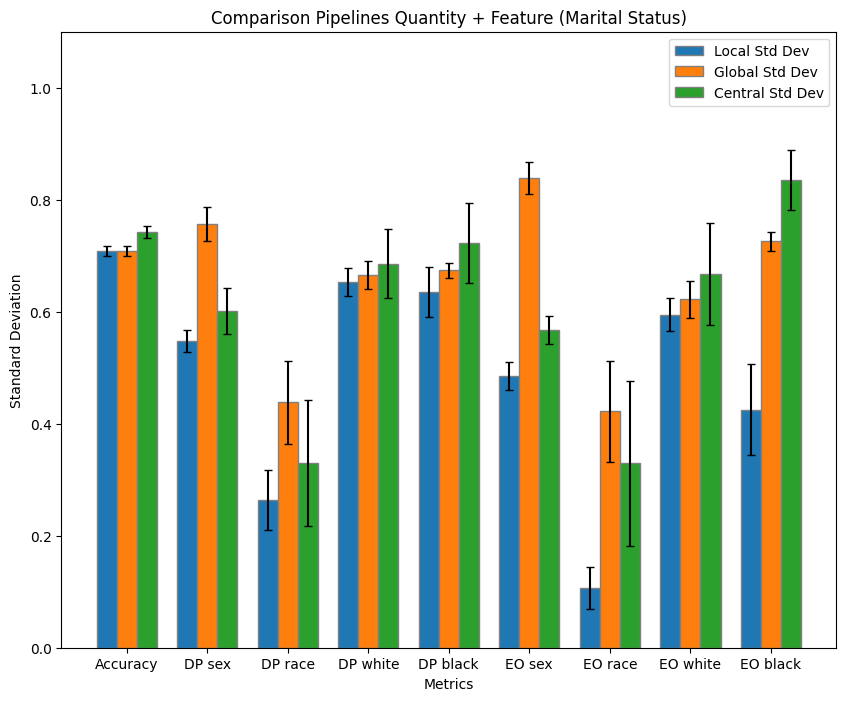

In [21]:
###########################################
# EXPERIMENT 17: Quantity + Feature (MS)
###########################################

file_path = 'results_experiments_17.txt'
with open(file_path, 'r') as file:
    ex17_content = file.read()

# Extract values
( ex17_local_accuracies, ex17_local_equalized_odds, ex17_local_demographic_parities,
 ex17_global_accuracies, ex17_global_equalized_odds, ex17_global_demographic_parities, 
 ex17_central_accuracies, ex17_central_equalized_odds, ex17_central_demographic_parities, 
 ex17_train_samples, ex17_test_samples) = extract_values(ex17_content)

ex17_local, ex17_global, ex17_central, ex17_diff_rq1, ex17_diff_rq2 = mean(ex17_local_accuracies, ex17_global_accuracies, ex17_central_accuracies, ex17_local_demographic_parities, ex17_global_demographic_parities, ex17_central_demographic_parities, ex17_local_equalized_odds, ex17_global_equalized_odds, ex17_central_equalized_odds)
print('Ex 17', ex17_local, ex17_global, ex17_central, ex17_diff_rq1, ex17_diff_rq2)

ex17_local_stdev, ex17_global_stdev, ex17_central_stdev, ex17_rq1_stdev, ex17_rq2_stdev = calculate_stdev(ex17_local_accuracies, ex17_global_accuracies, ex17_central_accuracies, ex17_local_demographic_parities, ex17_global_demographic_parities, ex17_central_demographic_parities, ex17_local_equalized_odds, ex17_global_equalized_odds, ex17_central_equalized_odds)
plot_stdev(ex17_local, ex17_global, ex17_central, ex17_local_stdev, ex17_global_stdev, ex17_central_stdev, 'Quantity + Feature (Marital Status)')

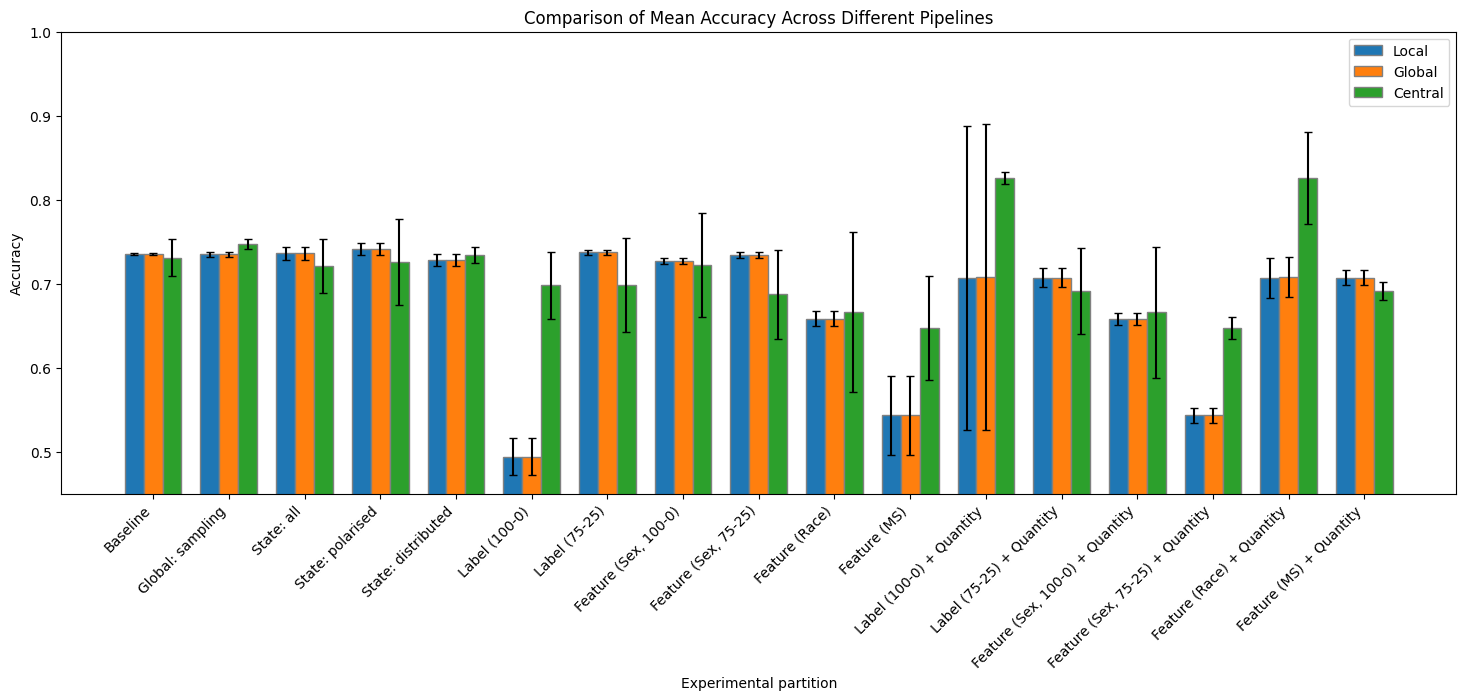

In [22]:
#######################################
# Accuracy per pipeline
#######################################

all_exp = ['Baseline', 'Global: sampling', 'State: all', 'State: polarised', 'State: distributed', 'Label (100-0)', 'Label (75-25)', 'Feature (Sex, 100-0)', 'Feature (Sex, 75-25)', 'Feature (Race)', 'Feature (MS)', 'Label (100-0) + Quantity', 'Label (75-25) + Quantity', 'Feature (Sex, 100-0) + Quantity', 'Feature (Sex, 75-25) + Quantity', 'Feature (Race) + Quantity', 'Feature (MS) + Quantity']

# accuracies
local_acc = [ex1_local[0], ex2_local[0], ex3_local[0], ex4_local[0], ex5_local[0], ex6_local[0], ex7_local[0], ex8_local[0], ex9_local[0], ex10_local[0], ex11_local[0], ex12_local[0], ex13_local[0], ex10_local[0], ex11_local[0], ex12_local[0], ex13_local[0]]
global_acc = [ex1_global[0], ex2_global[0], ex3_global[0], ex4_global[0], ex5_global[0], ex6_global[0], ex7_global[0], ex8_global[0], ex9_global[0], ex10_global[0], ex11_global[0], ex12_global[0], ex13_global[0], ex10_global[0], ex11_global[0], ex12_global[0], ex13_global[0]]
central_acc = [ex1_central[0], ex2_central[0], ex3_central[0], ex4_central[0], ex5_central[0], ex6_central[0], ex7_central[0], ex8_central[0], ex9_central[0], ex10_central[0], ex11_central[0], ex12_central[0], ex13_central[0], ex10_central[0], ex11_central[0], ex12_central[0], ex13_central[0]]

# standard deviations
local_acc_stdev = [ex1_local_stdev[0], ex2_local_stdev[0], ex3_local_stdev[0], ex4_local_stdev[0], ex5_local_stdev[0], ex6_local_stdev[0], ex7_local_stdev[0], ex8_local_stdev[0], ex9_local_stdev[0], ex10_local_stdev[0], ex11_local_stdev[0], ex12_local_stdev[0], ex13_local_stdev[0], ex14_local_stdev[0], ex15_local_stdev[0], ex16_local_stdev[0], ex17_local_stdev[0]]
global_acc_stdev = [ex1_global_stdev[0], ex2_global_stdev[0], ex3_global_stdev[0], ex4_global_stdev[0], ex5_global_stdev[0], ex6_global_stdev[0], ex7_global_stdev[0], ex8_global_stdev[0], ex9_global_stdev[0], ex10_global_stdev[0], ex11_global_stdev[0], ex12_global_stdev[0], ex13_global_stdev[0], ex14_global_stdev[0], ex15_global_stdev[0], ex16_global_stdev[0], ex17_global_stdev[0]]
central_acc_stdev = [ex1_central_stdev[0], ex2_central_stdev[0], ex3_central_stdev[0], ex4_central_stdev[0], ex5_central_stdev[0], ex6_central_stdev[0], ex7_central_stdev[0], ex8_central_stdev[0], ex9_central_stdev[0], ex10_central_stdev[0], ex11_central_stdev[0], ex12_central_stdev[0], ex13_central_stdev[0], ex14_central_stdev[0], ex15_central_stdev[0], ex16_central_stdev[0], ex17_central_stdev[0]]


bar_width = 0.25
r1 = np.arange(len(all_exp))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting the bars
plt.figure(figsize=(18, 6))
plt.bar(r1, local_acc, color='#1f77b4', yerr=local_acc_stdev, width=bar_width, edgecolor='grey', label='Local', capsize=3)
plt.bar(r2, global_acc, color='#ff7f0e', yerr=global_acc_stdev, width=bar_width, edgecolor='grey', label='Global', capsize=3)
plt.bar(r3, central_acc, color='#2ca02c', yerr=central_acc_stdev, width=bar_width, edgecolor='grey', label='Central', capsize=3)
plt.xticks(r2, all_exp, rotation=45, ha='right')

plt.ylim(0.45, 1.0)

# Adding title and labels
plt.title(f'Comparison of Mean Accuracy Across Different Pipelines')
plt.xlabel('Experimental partition')  # Replace with your actual x-axis label
plt.ylabel('Accuracy')

# Adding a legend
plt.legend()
plt.show()

Label 75-25 [0.0, -0.014, -0.322, 0.008, -0.084, nan, nan, nan, nan]
nan
nan
nan
nan


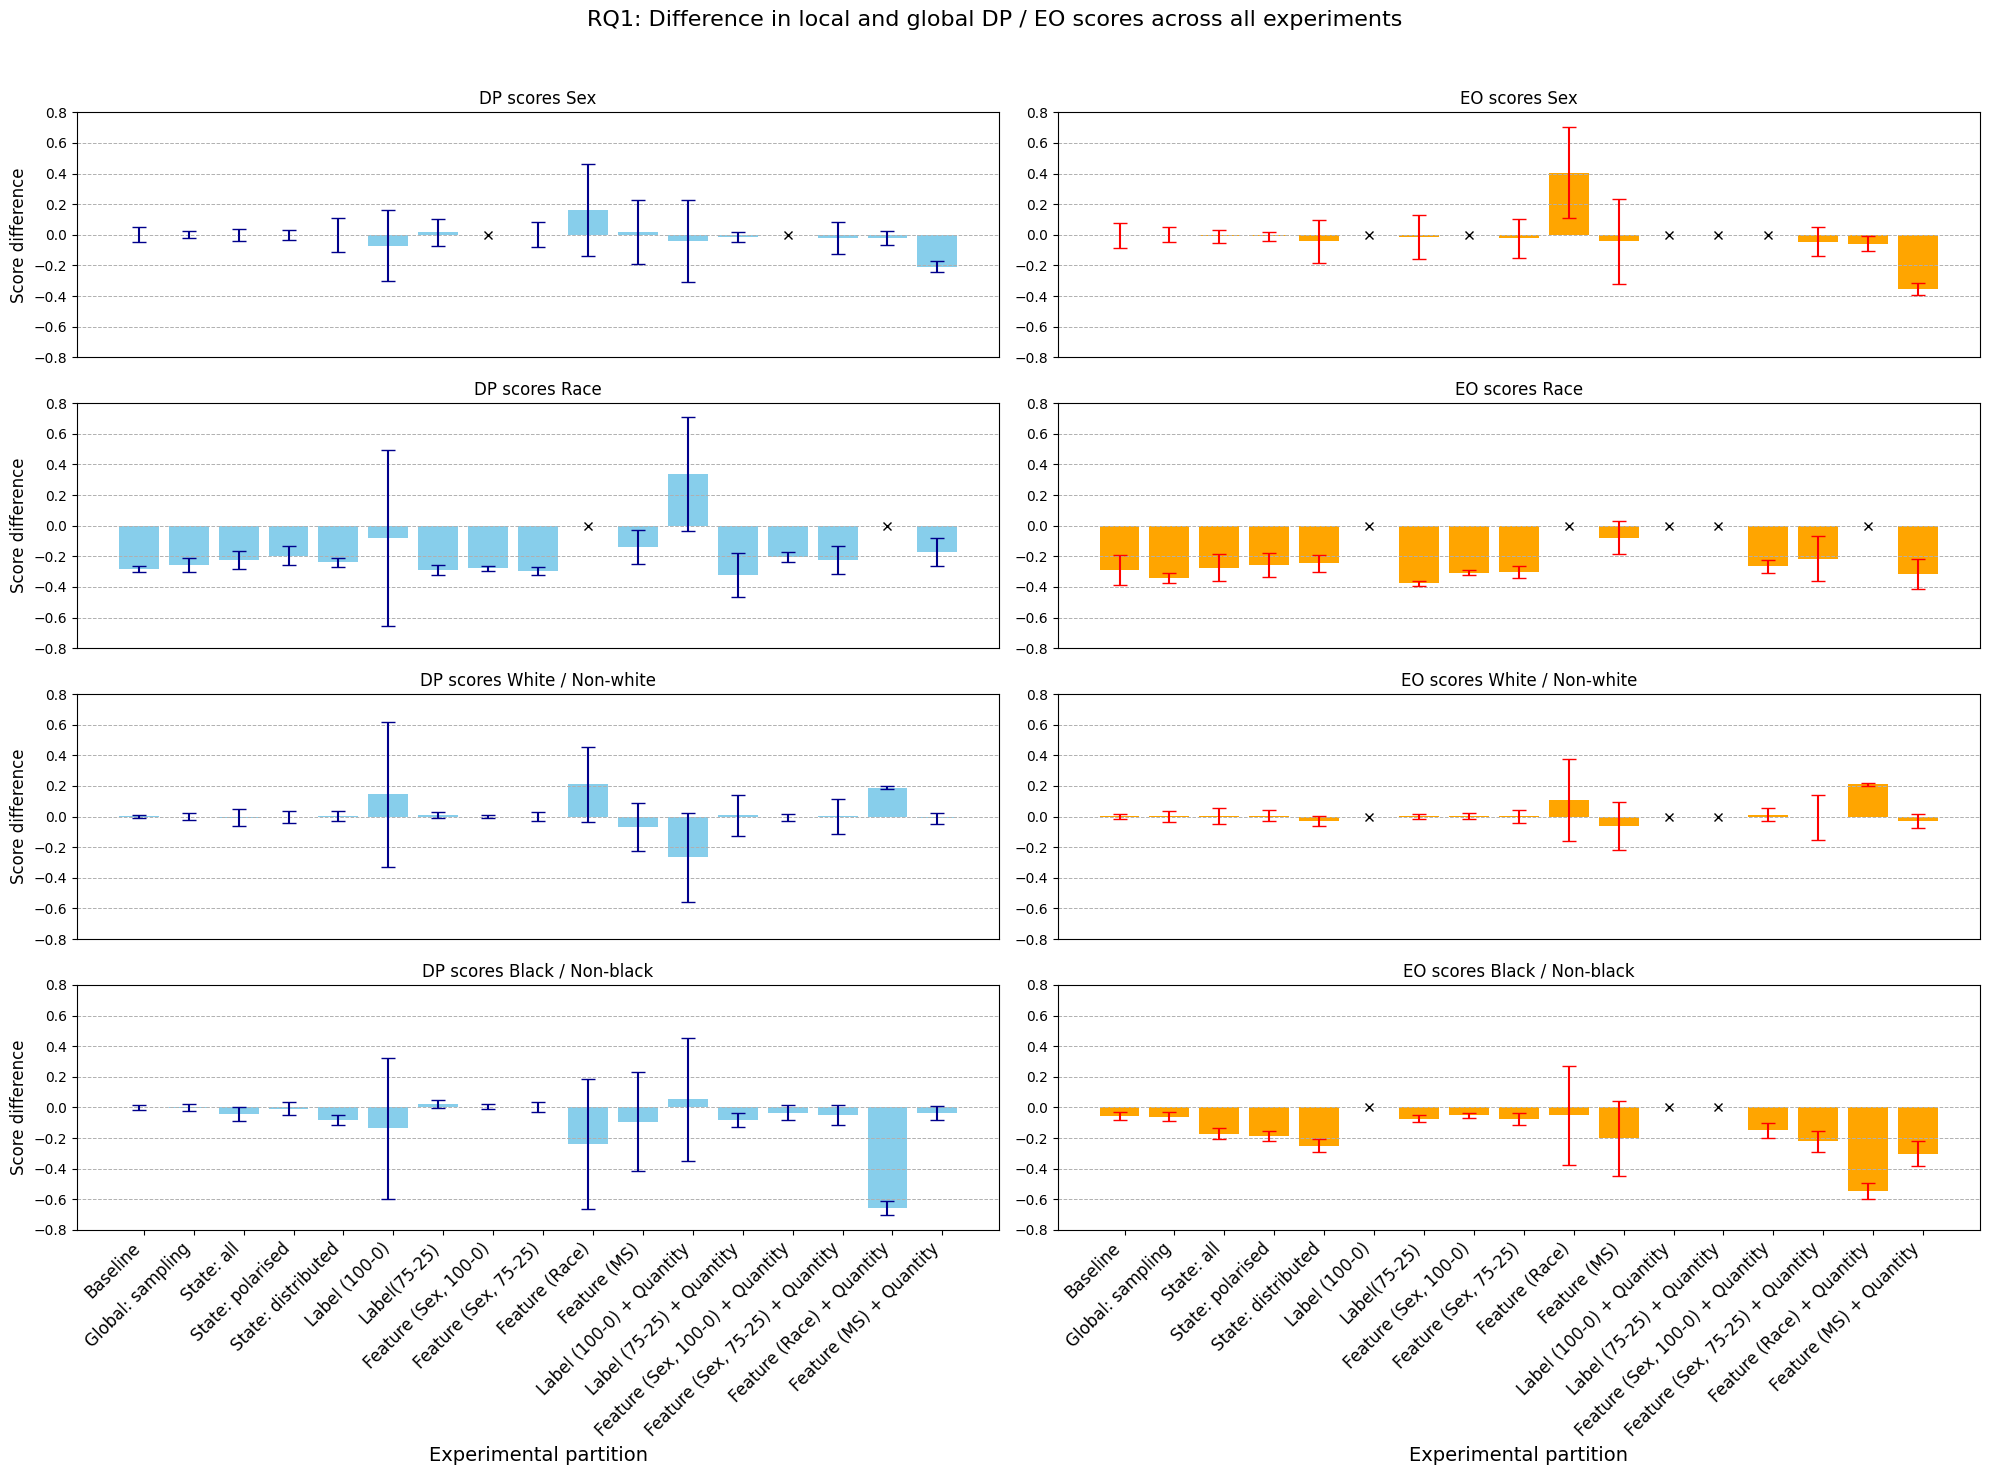

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define your lists for experiments and metrics
all_exp_values_rq1 = [ex1_diff_rq1, ex2_diff_rq1, ex3_diff_rq1, ex4_diff_rq1, ex5_diff_rq1, ex6_diff_rq1, ex7_diff_rq1, ex8_diff_rq1, ex9_diff_rq1, ex10_diff_rq1, ex11_diff_rq1, ex12_diff_rq1, ex13_diff_rq1, ex14_diff_rq1, ex15_diff_rq1, ex16_diff_rq1, ex17_diff_rq1]
print('Label 75-25', all_exp_values_rq1[12])
all_stdev_rq1 = [ex1_rq1_stdev, ex2_rq1_stdev, ex3_rq1_stdev, ex4_rq1_stdev, ex5_rq1_stdev, ex6_rq1_stdev, ex7_rq1_stdev, ex8_rq1_stdev, ex9_rq1_stdev, ex10_rq1_stdev, ex11_rq1_stdev, ex12_rq1_stdev, ex13_rq1_stdev, ex14_rq1_stdev, ex15_rq1_stdev, ex16_rq1_stdev, ex17_rq1_stdev]
all_exp = ['Baseline', 'Global: sampling', 'State: all', 'State: polarised', 'State: distributed', 'Label (100-0)', 'Label(75-25)', 'Feature (Sex, 100-0)', 'Feature (Sex, 75-25)', 'Feature (Race)', 'Feature (MS)', 'Label (100-0) + Quantity', 'Label (75-25) + Quantity', 'Feature (Sex, 100-0) + Quantity', 'Feature (Sex, 75-25) + Quantity', 'Feature (Race) + Quantity', 'Feature (MS) + Quantity']
metrics = ['Accuracy', 'DP sex', 'DP race', 'DP white', 'DP black', 'EO sex', 'EO race', 'EO white', 'EO black']
sens_attributes = ['Sex', 'Race', 'White / Non-white', 'Black / Non-black']

fig, ax = plt.subplots(4, 2, figsize=(20, 15))  
fig.suptitle('RQ1: Difference in local and global DP / EO scores across all experiments', fontsize=16)
colors = [cm.viridis(i/len(all_exp)) for i in range(len(all_exp))]

bar_width = 0.80
bar_positions_1 = [num for num in np.arange(0, len(all_exp))]
bar_positions_2 = [x + bar_width for x in bar_positions_1]
label_positions = [x + 0.1 for x in bar_positions_1]

for i, sens in enumerate(sens_attributes):
    if sens == 'Sex':
        dp_scores = [ex[i+1] if j not in [7, 13] else np.nan for j, ex in enumerate(all_exp_values_rq1)]
        eo_scores = [ex[i+5] if j not in [5, 7, 11, 13] else np.nan for j, ex in enumerate(all_exp_values_rq1)]
        stdev_dp = [stdev[i+1] if j not in [7, 13] else np.nan for j, stdev in enumerate(all_stdev_rq1)]
        stdev_eo = [stdev[i+5] if j not in [5, 7, 11, 13] else np.nan for j, stdev in enumerate(all_stdev_rq1)]
        positions_dp = [pos for j, pos in enumerate(bar_positions_1)]
        positions_eo = [pos for j, pos in enumerate(bar_positions_1)]

    elif sens == 'Race':
        dp_scores = [ex[i+1] if j not in [9, 15] else np.nan for j, ex in enumerate(all_exp_values_rq1) ]
        eo_scores = [ex[i+5] if j not in [5, 9, 11, 15] else np.nan for j, ex in enumerate(all_exp_values_rq1)]
        stdev_dp = [stdev[i+1] if j not in [9, 15] else np.nan for j, stdev in enumerate(all_stdev_rq1)]
        stdev_eo = [stdev[i+5] if j not in [5, 9, 11, 15] else np.nan for j, stdev in enumerate(all_stdev_rq1)]
        positions_dp = [pos for j, pos in enumerate(bar_positions_1)]
        positions_eo = [pos for j, pos in enumerate(bar_positions_1)]
    else:
        dp_scores = [ex[i+1] for j, ex in enumerate(all_exp_values_rq1)]
        eo_scores = [ex[i+5] if j not in [5, 11] else np.nan for j, ex in enumerate(all_exp_values_rq1)]
        stdev_dp = [stdev[i+1] for j, stdev in enumerate(all_stdev_rq1)]
        stdev_eo = [stdev[i+5]  if j not in [5, 11] else np.nan for j, stdev in enumerate(all_stdev_rq1)]
        positions_dp = bar_positions_1
        positions_eo = [pos for j, pos in enumerate(bar_positions_1)]

    ax[i, 0].bar(positions_dp, dp_scores, yerr=stdev_dp, width=bar_width, color='skyblue', ecolor='darkblue', capsize=5)
    ax[i, 1].bar(positions_eo, eo_scores, yerr=stdev_eo, width=bar_width, color='orange', ecolor='red', capsize=5)

        # Example positions where bars are omitted due to NaN or 0 values
    def find_cross_positions(data):
        return [i for i, value in enumerate(data) if np.isnan(value)]
    
    cross_positions_dp = find_cross_positions(dp_scores)
    cross_positions_eo = find_cross_positions(eo_scores)

    print(eo_scores[12])

    # Plot crosses at positions where bars are omitted
    ax[i, 0].plot(cross_positions_dp, [0] * len(cross_positions_dp), 'kx')
    ax[i, 1].plot(cross_positions_eo, [0] * len(cross_positions_eo), 'kx')
    
    ax[i, 0].set_ylim(-0.8, 0.8)
    ax[i, 0].set_yticks(np.arange(-0.8, 1.0, 0.20))
    ax[i, 1].set_ylim(-0.8, 0.8)
    ax[i, 1].set_yticks(np.arange(-0.8, 1.0, 0.20))
    
    ax[i, 0].set_ylabel('Score difference', fontsize=12)
    ax[i, 0].set_title(f'DP scores {sens}', fontsize=12)
    ax[i, 1].set_title(f'EO scores {sens}', fontsize=12)
    
    ax[i, 0].grid(axis='y', linestyle='--', linewidth=0.7)
    ax[i, 1].grid(axis='y', linestyle='--', linewidth=0.7)
    
    if i == len(sens_attributes) - 1:
        ax[i, 0].set_xticks(label_positions)
        ax[i, 0].set_xticklabels(all_exp, rotation=45, ha='right', fontsize=12)
        ax[i, 0].set_xlabel('Experimental partition', fontsize=14)
        
        ax[i, 1].set_xticks(label_positions)
        ax[i, 1].set_xticklabels(all_exp, rotation=45, ha='right', fontsize=12)
        ax[i, 1].set_xlabel('Experimental partition', fontsize=14)
    else:
        ax[i, 0].set_xticks([])
        ax[i, 1].set_xticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to make room for the title
plt.show()


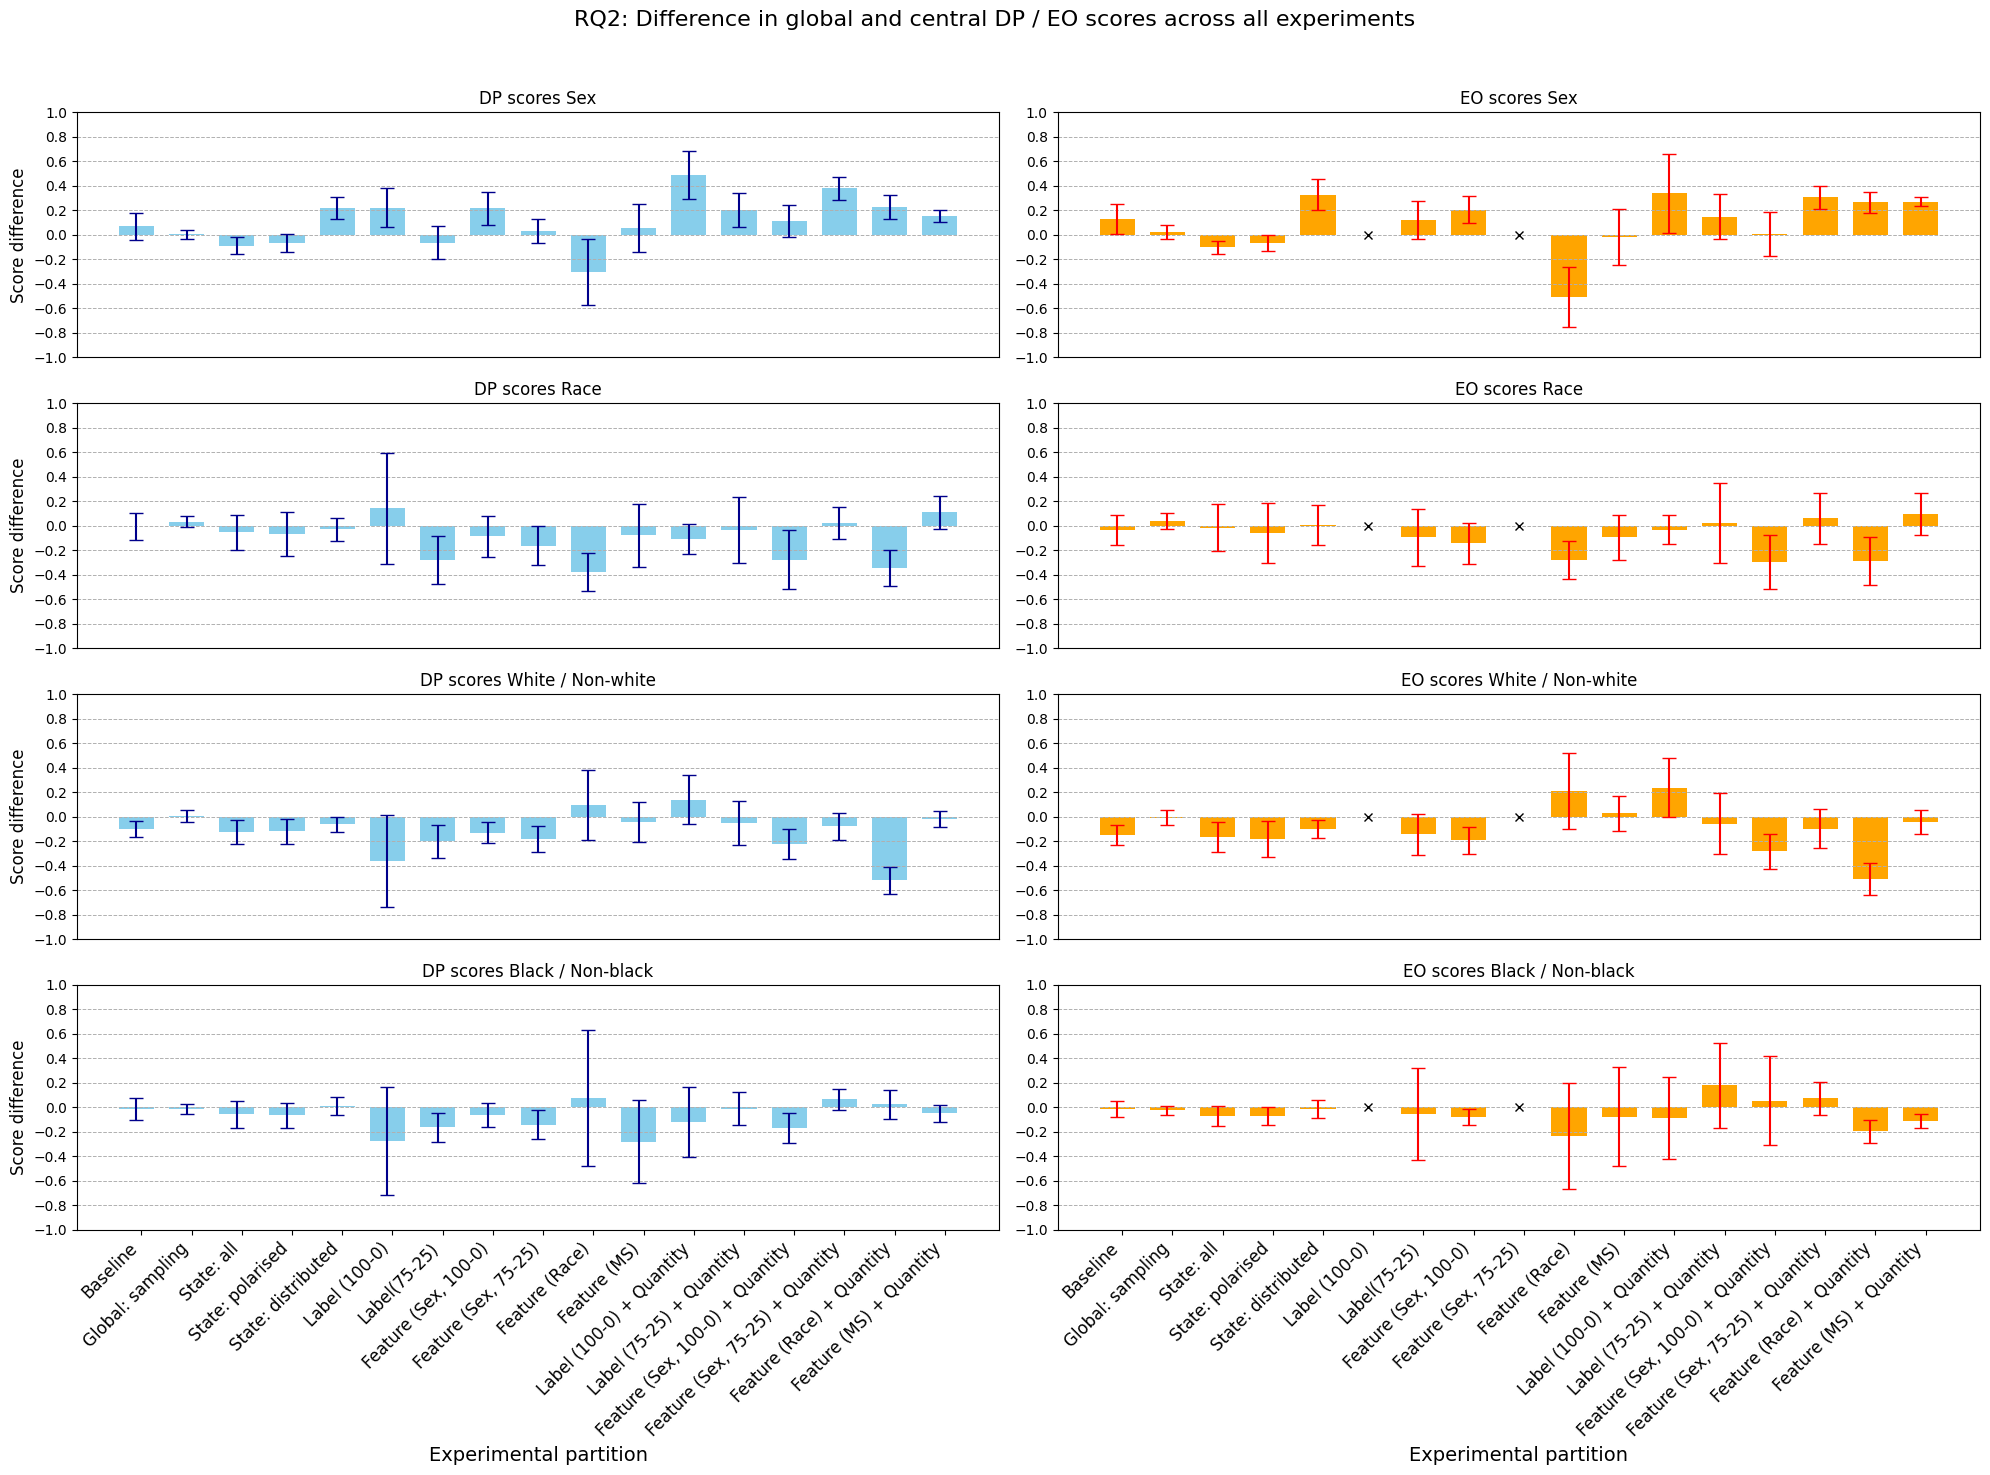

In [24]:
# Plots for RQ2

# acc=0, dp_sex=1, dp_race=2, dp_white=3, dp_black=4, eo_sex=5, eo_race=6, eo_white=7, eo_black=8 
all_exp_values_rq2 = [ex1_diff_rq2, ex2_diff_rq2, ex3_diff_rq2, ex4_diff_rq2, ex5_diff_rq2, ex6_diff_rq2, ex7_diff_rq2, ex8_diff_rq2, ex9_diff_rq2, ex10_diff_rq2, ex11_diff_rq2, ex12_diff_rq2, ex13_diff_rq2, ex14_diff_rq2, ex15_diff_rq2, ex16_diff_rq2, ex17_diff_rq2]
all_stdev_rq2 = [ex1_rq2_stdev, ex2_rq2_stdev, ex3_rq2_stdev, ex4_rq2_stdev, ex5_rq2_stdev, ex6_rq2_stdev, ex7_rq2_stdev, ex8_rq2_stdev, ex9_rq2_stdev, ex10_rq2_stdev, ex11_rq2_stdev, ex12_rq2_stdev, ex13_rq2_stdev, ex14_rq2_stdev, ex15_rq2_stdev, ex16_rq2_stdev, ex17_rq2_stdev]
all_exp = ['Baseline', 'Global: sampling', 'State: all', 'State: polarised', 'State: distributed', 'Label (100-0)', 'Label(75-25)', 'Feature (Sex, 100-0)', 'Feature (Sex, 75-25)', 'Feature (Race)', 'Feature (MS)', 'Label (100-0) + Quantity', 'Label (75-25) + Quantity', 'Feature (Sex, 100-0) + Quantity', 'Feature (Sex, 75-25) + Quantity', 'Feature (Race) + Quantity', 'Feature (MS) + Quantity']
metrics = ['Accuracy', 'DP sex', 'DP race', 'DP white', 'DP black', 'EO sex', 'EO race', 'EO white', 'EO black']
sens_attributes = ['Sex', 'Race', 'White / Non-white', 'Black / Non-black']

fig, ax = plt.subplots(4, 2, figsize=(20, 15)) 
fig.suptitle('RQ2: Difference in global and central DP / EO scores across all experiments', fontsize=16)
colors = [cm.viridis(i/len(all_exp)) for i in range(len(all_exp))]

bar_width = 0.70
bar_positions_1 = [num for num in np.arange(0, len(all_exp))]
bar_positions_2 = [x + bar_width for x in bar_positions_1]
label_positions = [x + 0.1 for x in bar_positions_1]

for i, sens in enumerate(sens_attributes):
    dp_scores = [ex[i+1] for j, ex in enumerate(all_exp_values_rq2)]
    eo_scores = [ex[i+5] if j not in [5, 8] else np.nan for j, ex in enumerate(all_exp_values_rq2)]
    stdev_dp = [stdev[i+1] for j, stdev in enumerate(all_stdev_rq2)]
    stdev_eo = [stdev[i+5] if j not in [5, 8] else np.nan for j, stdev in enumerate(all_stdev_rq2)]

    ax[i, 0].bar(bar_positions_1, dp_scores, yerr=stdev_dp, width=bar_width, color='skyblue', ecolor='darkblue', capsize=5)
    ax[i, 1].bar(bar_positions_1, eo_scores, yerr=stdev_eo, width=bar_width, color='orange', ecolor='red', capsize=5)

    # Example positions where bars are omitted due to NaN or 0 values
    def find_cross_positions(data):
        return [i for i, value in enumerate(data) if np.isnan(value)]
    
    cross_positions_dp = find_cross_positions(dp_scores)
    cross_positions_eo = find_cross_positions(eo_scores)

    # Plot crosses at positions where bars are omitted
    ax[i, 0].plot(cross_positions_dp, [0] * len(cross_positions_dp), 'kx')
    ax[i, 1].plot(cross_positions_eo, [0] * len(cross_positions_eo), 'kx')
    
    ax[i, 0].set_ylim(-1, 1)
    ax[i, 0].set_yticks(np.arange(-1.0, 1.2, 0.20))
    ax[i, 1].set_ylim(-1, 1)
    ax[i, 1].set_yticks(np.arange(-1.0, 1.2, 0.20))
    
    ax[i, 0].set_ylabel('Score difference', fontsize=12)
    ax[i, 0].set_title(f'DP scores {sens}', fontsize=12)
    ax[i, 1].set_title(f'EO scores {sens}', fontsize=12)
    
    ax[i, 0].grid(axis='y', linestyle='--', linewidth=0.7)
    ax[i, 1].grid(axis='y', linestyle='--', linewidth=0.7)
    
    if i == len(sens_attributes) - 1:
        ax[i, 0].set_xticks(label_positions)
        ax[i, 0].set_xticklabels(all_exp, rotation=45, ha='right', fontsize=12)
        ax[i, 0].set_xlabel('Experimental partition', fontsize=14)
        
        ax[i, 1].set_xticks(label_positions)
        ax[i, 1].set_xticklabels(all_exp, rotation=45, ha='right', fontsize=12)
        ax[i, 1].set_xlabel('Experimental partition', fontsize=14)
    else:
        ax[i, 0].set_xticks([])
        ax[i, 1].set_xticks([])

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the layout to make room for the title
plt.show()

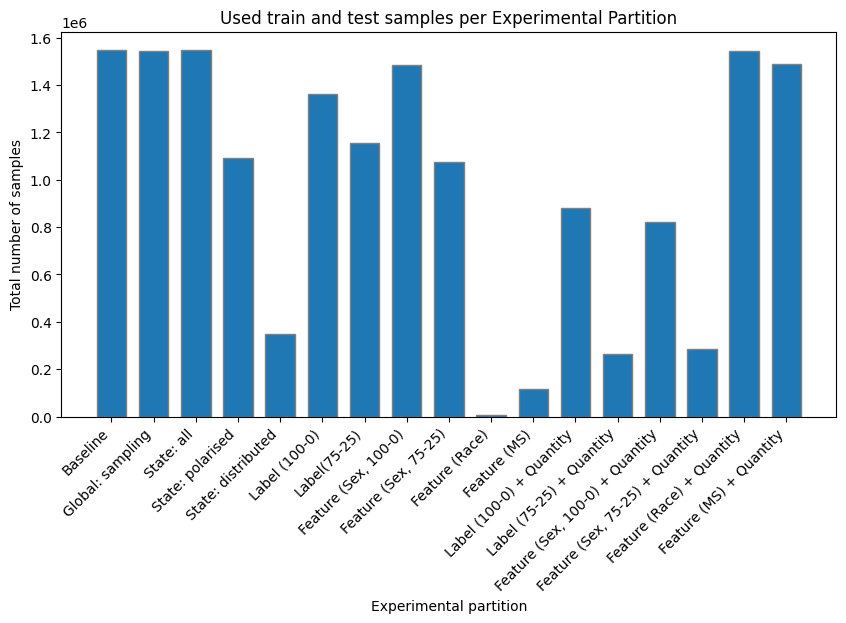

In [25]:
test_sizes = [ex1_test_samples, ex2_test_samples, ex3_test_samples, ex4_test_samples, ex5_test_samples, ex6_test_samples, ex7_test_samples, ex8_test_samples, ex9_test_samples, ex10_test_samples, ex11_test_samples, ex12_test_samples, ex13_test_samples, ex14_test_samples, ex15_test_samples, ex16_test_samples, ex17_test_samples]
train_sizes = [ex1_train_samples, ex2_train_samples, ex3_train_samples, ex4_train_samples, ex5_train_samples, ex6_train_samples, ex7_train_samples, ex8_train_samples, ex9_train_samples, ex10_train_samples, ex11_train_samples, ex12_train_samples, ex13_train_samples, ex14_train_samples, ex15_train_samples, ex16_train_samples, ex17_train_samples]
sizes = [train + test for train, test in zip(train_sizes, test_sizes)]
all_exp = ['Baseline', 'Global: sampling', 'State: all', 'State: polarised', 'State: distributed', 'Label (100-0)', 'Label(75-25)', 'Feature (Sex, 100-0)', 'Feature (Sex, 75-25)', 'Feature (Race)', 'Feature (MS)', 'Label (100-0) + Quantity', 'Label (75-25) + Quantity', 'Feature (Sex, 100-0) + Quantity', 'Feature (Sex, 75-25) + Quantity', 'Feature (Race) + Quantity', 'Feature (MS) + Quantity']

bar_width = 0.7
r1 = np.arange(len(all_exp))
r2 = [x for x in r1]

# Plotting the bars
plt.figure(figsize=(10, 5))
plt.bar(r1, sizes, color='#1f77b4', width=bar_width, edgecolor='grey', capsize=3)
# plt.bar(r2, test_sizes, color='#ff7f0e', width=bar_width, edgecolor='grey', label='Test', capsize=3)
plt.xticks(r2, all_exp, rotation=45, ha='right')

# Adding title and labels
plt.title(f'Used train and test samples per Experimental Partition')
plt.xlabel('Experimental partition')  # Replace with your actual x-axis label
plt.ylabel('Total number of samples')

# Adding a legend
plt.show()